# Projet 4 : Anticipez les besoins en consommation électrique de bâtiments

La ville de Seatle souhaite  atteindre son objectif de ville neutre en émissions de carbonne en 2050. Pour cela, elle souhaite dans un premier temps :

- Obtenir une prédiction des émissions de Co2 et de la consommation totale d'énergie des bâtiments pour lesquels elles n'ont pas été mesurées 

- Evaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions


Les données des bâtiments sont disponibles à  cette adresse : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv


Démarche : 

1/ Pré-traitement des données
- Concaténation des données de 2015 et 2016
- Nettoyage des données
- Séléction des variables importantes
- Analyse des données
- Préparation des données
- Sélection et entrainment de modèles

2/ L'énergie totale est prédite à partir des caractéristiques des bâtiments

3/ La proportion de chaque source d'énergie (électricité, gas...) est prédite, à partir des mêmes variables que pour la prédiction de la consommation d'énergie totale

4/ Les émissions de Co2 sont ensuite prédites à partir des caractéristiques des bâtiments ainsi que des prédictions de l'énergie totale de la proportion de chaque source d'énergie

5/ L'impacte de l'ENERGY Star Score est évalué

Des informations complémentaires sur le calcul de l'Energy Star Score sont dispononibles ici :https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100

#### Chargement des librairies

In [1]:
# Librairies communes pour le ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import pickle
from scipy.stats import uniform
from textwrap import wrap

# Séparateur de jeu de données
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import clone

# Métrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_array

# Cross validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.feature_extraction import FeatureHasher

#### Lecture des données

In [2]:
# Chemin d'accès aux données
path = "data/"
# Lecture des données
data_2015 = pd.read_csv(os.path.join(path, "2015-building-energy-benchmarking.csv"), sep=",")
data_2016 = pd.read_csv(os.path.join(path, "2016-building-energy-benchmarking.csv"), sep=",")

Il y a un relévé de consommation pour l'année 2015 et un autre pour l'année 2016

## 1. Description des données

### 1.1 Affichage des données

In [3]:
print("Il y a {} batiments différents pour le relevé 2015".format(data_2015["OSEBuildingID"].nunique()))
# Affichage des 5 premières lignes des données 2015
data_2015.head(3)

Il y a 3340 batiments différents pour le relevé 2015


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'needs_recoding': ...",7,DOWNTOWN,1927,...,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'needs_recoding': ...",7,DOWNTOWN,1996,...,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'needs_recoding': ...",7,DOWNTOWN,1969,...,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN


In [4]:
print("Il y a {} batiments différents pour le relevé 2016".format(data_2016["OSEBuildingID"].nunique()))
# Affichage des 3 premières lignes des données 2016
data_2016.head()

Il y a 3376 batiments différents pour le relevé 2016


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


### 1.2 Structure des données

In [5]:
# Structure : entrées, colonnes, types et valeurs non nulles
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 42 columns):
OSEBuildingID                        3340 non-null int64
DataYear                             3340 non-null int64
BuildingType                         3340 non-null object
PrimaryPropertyType                  3340 non-null object
PropertyName                         3340 non-null object
TaxParcelIdentificationNumber        3338 non-null object
Location                             3340 non-null object
CouncilDistrictCode                  3340 non-null int64
Neighborhood                         3340 non-null object
YearBuilt                            3340 non-null int64
NumberofBuildings                    3340 non-null int64
NumberofFloors                       3332 non-null float64
PropertyGFATotal                     3340 non-null int64
PropertyGFAParking                   3340 non-null int64
PropertyGFABuilding(s)               3340 non-null int64
ListOfAllPropertyUseTypes     

In [6]:
# Structure : entrées, colonnes, types et valeurs non nulles
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
OSEBuildingID                      3376 non-null int64
DataYear                           3376 non-null int64
BuildingType                       3376 non-null object
PrimaryPropertyType                3376 non-null object
PropertyName                       3376 non-null object
Address                            3376 non-null object
City                               3376 non-null object
State                              3376 non-null object
ZipCode                            3360 non-null float64
TaxParcelIdentificationNumber      3376 non-null object
CouncilDistrictCode                3376 non-null int64
Neighborhood                       3376 non-null object
Latitude                           3376 non-null float64
Longitude                          3376 non-null float64
YearBuilt                          3376 non-null int64
NumberofBuildings                  3368 non-null float

### 1.3 Concaténation des données

Il y a 2 relevés de données pour les bâtiments étudiés (2015 et 2016). Il s'agit alors de concaténer les données en détectant les doublons et en assurant la conrrespondance des colonnes

#### Affichage des colonnes non communes aux deux années

In [7]:
# Colonnes data 2015 qui ne sont pas en 2016
[col for col in data_2015 if col not in data_2016]

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment']

In [8]:
# Colonnes data 2016 qui ne sont pas en 2015
[col for col in data_2016 if col not in data_2015]

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

#### Affichage des colonnes communes aux deux années

In [9]:
[col for col in data_2016 if col in data_2015]

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'ComplianceStatus',
 'Outlier']

#### On assure l'unicité des bâtiments dans les deux relévés via la colonne OSEBuildingID

In [10]:
# On récupère les données batiments 2016 dont les OSEBuildingID ne sont pas das les données 2015
OSEBuildingID = [OSEBuildingID for OSEBuildingID in data_2015["OSEBuildingID"] if OSEBuildingID not in data_2016["OSEBuildingID"].values]
#data_2016 = data_2016[data_2016["OSEBuildingID"].isin(OSEBuildingID)]
print("Il y a pour le relevé 2015 : {} bâtiments non existants dans le relevé 2016".format(len(OSEBuildingID)))

Il y a pour le relevé 2015 : 56 bâtiments non existants dans le relevé 2016


Il s'agit de la même ville donc les 2 relevés contiennent logiquement une majorité de bâtiments communs 

#### Renommage des colonnes ''GHGEmissions(MetricTonsCO2e)' et 'GHGEmissionsIntensity(kgCO2e/ft2)'

In [11]:
# On renomme les colonnes de 2015 pour que les noms des variables soient les mêmes que pour 2016 (Energy et CO2)
data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                          'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'},
                 inplace=True)

#### Renommage de la colonne 'Comment'

In [12]:
data_2015.rename(columns={'Comment': 'Comments'},
                 inplace=True)

Les colonnes 'GHGEmissions(MetricTonsCO2e)' et 'GHGEmissionsIntensity(kgCO2e/ft2)' du relevé 2015 sont renommées pour les faire correspondre aux noms des colonnes du relevé 2016

#### Variable Location : Longitude et Latitude dans les données 2015

In [13]:
# On intégre la latitude et la longitude du batiment, obtenus à partir de la colonne 'Location'
latitudes = []
longitudes = []
for loc in data_2015["Location"]:
    latitudes.append(float(loc.split(":")[1].split("'")[1]))
    longitudes.append(float(loc.split(':')[8].split("'")[1]))

data_2015.drop(columns=['Location'], inplace=True)
data_2015["Longitude"] = longitudes
data_2015["Latitude"] = latitudes

#### Traitement de 'OtherFuelUse(kBtu)'

In [14]:
# On ajoute la colonne "OtherFuelUse(kBtu)" remplie de 0
data_2016["OtherFuelUse(kBtu)"] = 0

# On récupère tous les bâtiments dont la différence entre l'energie totale
# et les énergies des différentes est supérieur à 1e3 (valeur au delà de laquelle on sait
# que la différence n'est pas du à des erreurs de mesure)
cond_to_fill = (data_2016["SiteEnergyUse(kBtu)"]
                - data_2016["SteamUse(kBtu)"]
                - data_2016["Electricity(kBtu)"]
                - data_2016["NaturalGas(kBtu)"]) > 1e3

# On remplace les valeurs des bâtiments trouvés précedemment par la différence calculé
data_2016.loc[cond_to_fill, "OtherFuelUse(kBtu)"] = (data_2016["SiteEnergyUse(kBtu)"]
                                                    - data_2016["SteamUse(kBtu)"]
                                                    - data_2016["Electricity(kBtu)"]
                                                    - data_2016["NaturalGas(kBtu)"])

# Pour l'année 2015, les valeurs manquantes
# de la colonne "OtherFuelUse(kBtu)" sont remplacés par des 0
data_2015["OtherFuelUse(kBtu)"].fillna(0, inplace=True)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

#### Suppression des colonnes non communes

In [15]:
# Suppression des dernières colonnes de 2016
data_2016.drop(columns=[col for col in data_2016 if col not in data_2015],
               inplace=True)

#### Convertie les variables numériques qui sont des variables catégorielles

In [16]:
# Convertie 'CouncilDistrictCode' en variable catégorielle
data_2015["CouncilDistrictCode"] = data_2015["CouncilDistrictCode"].apply(str)
data_2016["CouncilDistrictCode"] = data_2016["CouncilDistrictCode"].apply(str)

La variable 'CouncilDistrictCode' est de type "int" mais il s'agit plutôt d'une variable catégorielle donc elle est convertie en "string".

#### Concaténation données 2015 et 2016

In [17]:
# On assemble les données de 2015 et 2016
data = pd.concat([data_2015, data_2016], sort=False)

In [18]:
# On regorupe les données de bâtiments communs, en moyennant les valeurs
data = data.groupby(["OSEBuildingID"]).agg("mean")

In [19]:
# Liste des variables catégorielles
cat_attribs = list(data_2015.drop(columns=list(data.columns) + ["OSEBuildingID"]).columns)
# On ajoute les valeurs des variables catégorielles pour les bâtiments de 2016
data[cat_attribs] = data_2016.set_index("OSEBuildingID")[cat_attribs]
# On ajoute les valeurs des variables catégorielles pour les bâtiments uniques de 2015
OSEBuildingID_2015 = [ID for ID in data_2015["OSEBuildingID"] if ID not in data_2016["OSEBuildingID"].values]
data[cat_attribs] = data_2016.set_index("OSEBuildingID")[cat_attribs]
data.loc[OSEBuildingID_2015, cat_attribs] = data_2015.set_index("OSEBuildingID")\
                                                     .loc[OSEBuildingID_2015, cat_attribs]

In [20]:
print("Le nombre de bâtiments uniques est de : {}".format(len(data)))

Le nombre de bâtiments uniques est de : 3432


### 1.4 Variables catégorielles et numériques

#### Variables catégorielles

In [21]:
# Les colonnes object dtypes sont séléctionnés
obj_columns = list(data.select_dtypes(include=['object', 'bool']).columns)

In [22]:
print("Les variables catégorielles sont les suivantes : \n")
for categ in obj_columns :
    print(categ, ":", data[categ].nunique())

Les variables catégorielles sont les suivantes : 

BuildingType : 8
PrimaryPropertyType : 26
PropertyName : 3418
TaxParcelIdentificationNumber : 3321
CouncilDistrictCode : 7
Neighborhood : 19
ListOfAllPropertyUseTypes : 472
LargestPropertyUseType : 57
SecondLargestPropertyUseType : 50
ThirdLargestPropertyUseType : 44
YearsENERGYSTARCertified : 65
DefaultData : 4
Comments : 1
ComplianceStatus : 4
Outlier : 3


#### Variables numériques

In [23]:
# Les colonnes float64 sont séléctionnés
num_columns = list(data.select_dtypes(include=['float64', 'int64']).columns)
print("Les variables numériques sont les suivantes : \n")
for num in num_columns :
    print(num)

Les variables numériques sont les suivantes : 

DataYear
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
LargestPropertyUseTypeGFA
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseTypeGFA
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
OtherFuelUse(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity
Longitude
Latitude


## 2. Nettoyage des données

### 2.1 Affiche des données manquantes

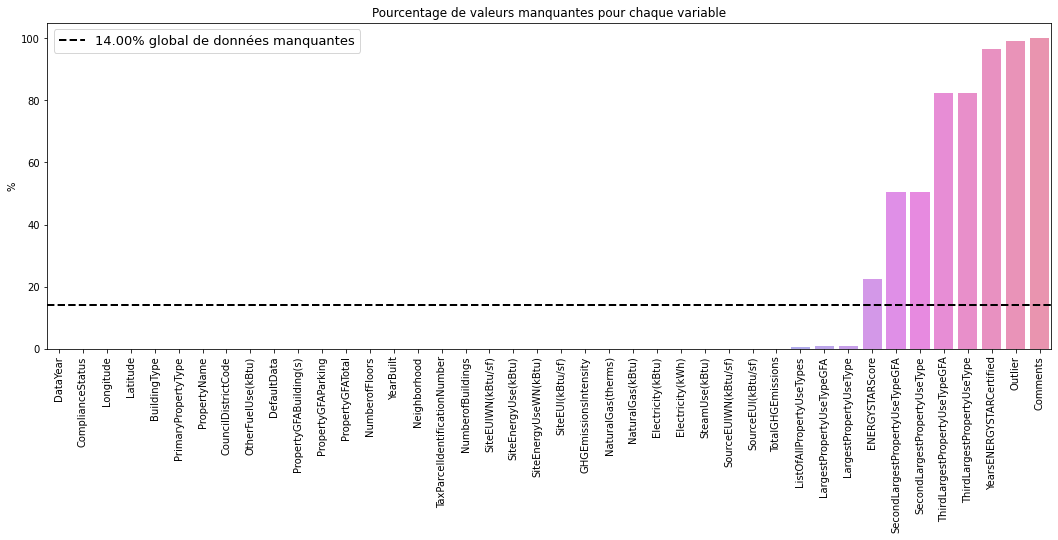

In [24]:
#On calcule la proportion de données manquantes pour chaque colonne et on plot !
fig = plt.figure(figsize=(18, 6))

null_prop = data.isnull().sum(axis=0).sum()/len(data)/len(data.columns)*100
plt.axhline(y=null_prop, color='k', linestyle='--', lw=2)
plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)

null = data.isnull().sum(axis=0).sort_values()/len(data)*100
sns.barplot(null.index, null.values)
plt.ylabel("%")
plt.title("Pourcentage de valeurs manquantes pour chaque variable")
plt.xticks(rotation=90)
plt.show()

### 2.2 Traitement des colonnes fortement non renseignés

#### Remplacement de quelques valeurs manquantes

Les colonnes 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType' et 'ThirdLargestPropertyUseTypeGFA' contiennent beaucoup de valeurs manquantes. On considère que les bâtiments dont les valeurs sont manquantes pour ces variables ne possèdent pas de deuxième et troisième utilisation donc on ajoute une catégorie aux types d'utilisation et on remplace les valeurs de surface par 0. 

In [25]:
# Les valeurs manquantes sont remplacés par une catégorie supplémentaire
data["SecondLargestPropertyUseType"].fillna("Nothing", inplace=True)

# Les valeurs manquantes sont remplacés par 0
data["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)

In [26]:
# Les valeurs manquantes sont remplacés par une catégorie supplémentaire
data["ThirdLargestPropertyUseType"].fillna("Nothing", inplace=True)

# Les valeurs manquantes sont remplacés par 0
data["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)

#### Suppression des variables non renseignés

Les colonnes dont les données manquantes sont supérieurs à 25% sont supprimées

In [27]:
# On supprime les colonnes dont les données manquantes sont supérieurs à 25%
null = data.isnull().sum(axis=0).sort_values()/len(data)*100
cond = null < 25
cond = cond[cond == True]
data = data.loc[:, cond.index]

### 2.3 Suppresion des colonnes non pertinentes

In [28]:
# Liste des colonnes qui semblent sans intérêt pour la prédiction
col_to_del = ["GHGEmissionsIntensity", 
              "NaturalGas(therms)", 
              "DataYear", 
              'TaxParcelIdentificationNumber', 
              'PropertyName']

# Suppression des colonnes non pertinentes
data.drop(columns=col_to_del, inplace=True)

# Nouvelle liste des colonnes numériques
num_columns = list(data.select_dtypes(include='float64').columns)

### 2.4 Traitement des valeurs abérantes et des outliers

#### 2.4.1 Valeurs abérantes et cibles manquantes

Les bâtiments dont les valeurs cibles sont manquantes ou négatives sont supprimés

In [29]:
for label in ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'] :
    print("Le nombre de bâtiments dont {} est manquant est de : {}".format(label, data[label].isna().sum()))
    print("Le nombre de bâtiments dont {} est <=0 est de : {}".format(label, sum(data[label]<0.0)))
    data = data[data[label]>=0.0] # Suppresion des bâtiments dont la valeur est négative ou nulle

Le nombre de bâtiments dont TotalGHGEmissions est manquant est de : 4
Le nombre de bâtiments dont TotalGHGEmissions est <=0 est de : 0
Le nombre de bâtiments dont SiteEnergyUse(kBtu) est manquant est de : 0
Le nombre de bâtiments dont SiteEnergyUse(kBtu) est <=0 est de : 0


Remplacement des valeurs négatives de surface et de bâtiments par NaN

In [30]:
for label in ["PropertyGFAParking", "PropertyGFABuilding(s)"] :
    print("Le nombre de bâtiments dont {} est <0 est de : {}".format(label, sum(data[label]<0.0)))
    values_to_nan = data.loc[data[label]<0, label].unique()
    data[label].replace(values_to_nan, np.nan, inplace=True)


Le nombre de bâtiments dont PropertyGFAParking est <0 est de : 2
Le nombre de bâtiments dont PropertyGFABuilding(s) est <0 est de : 1


On s'assure que la consommation de chaque source d'énergie est égale à la consommation totale (marge de 1%)

In [31]:
list_energy = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', "OtherFuelUse(kBtu)"]
data["diff_energy"] = abs((data[list_energy].sum(axis=1) - data["SiteEnergyUse(kBtu)"]))/(data["SiteEnergyUse(kBtu)"]+0.0001)
print("Le nombre de bâtiments dont la consommation de chaque source d'énergie n'est pas égale à la consommation totale est de : {}" \
      .format(sum(data["diff_energy"]>1e-4)))
data = data[data["diff_energy"]<1e-4]
data.drop(columns=["diff_energy"], inplace=True)

Le nombre de bâtiments dont la consommation de chaque source d'énergie n'est pas égale à la consommation totale est de : 22


#### 2.4.2 Traitement des Outliers

Il est intéressant d'observer les distributions des variables à prédire pour savoir si des bâtiments ont des valeurs outliers, i.e soit très hautes soit très basses.

#### Variables énergie et Co2 sans transformation

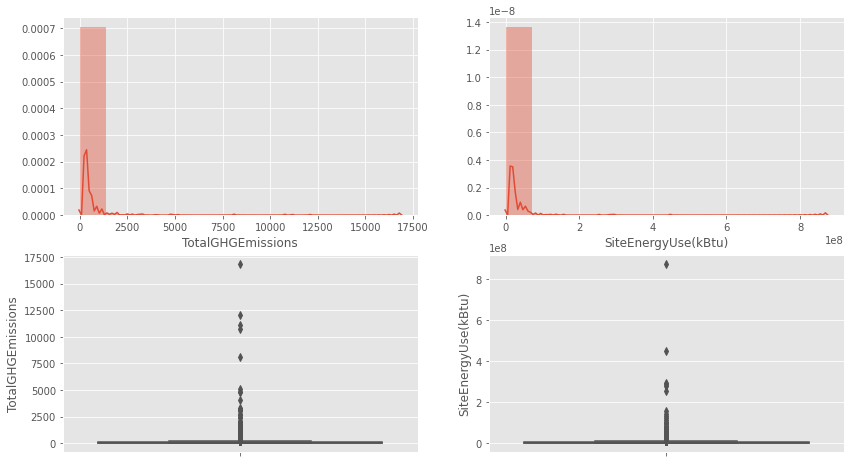

In [32]:
plt.style.use('ggplot')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label], bins=int(1 + np.log2(len(data))))
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label], orient="v")
plt.show()

Des bâtiments à forte consommation énergétique et fortes émissions de Co2, en nombre non négligeable, rendent la distribution asymétrique

#### Variables énergie et Co2 avec transformation logarithmique

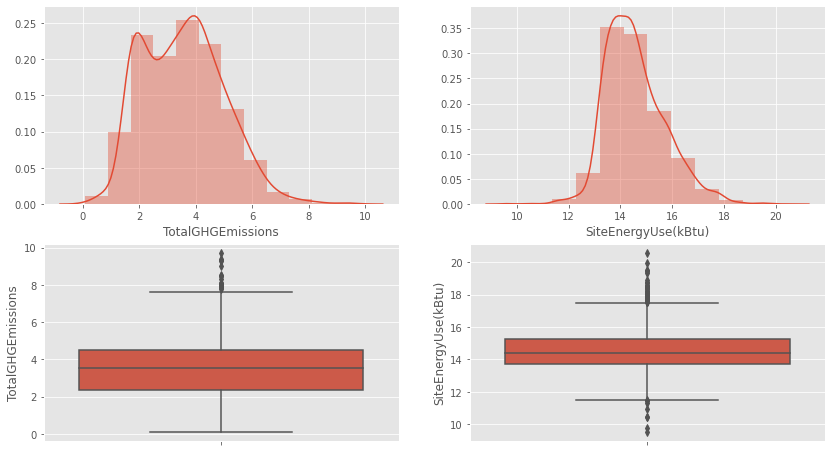

In [33]:
plt.style.use('ggplot')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(data))))
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label].apply(lambda x : np.log(1 + x)), orient="v")
plt.show()

Désormais, nos variables à prédire présentent des distributions "normales", la méthode de Tukey peut être donc appliqué pour supprimer les valeurs outliers.

Calcul des IQ pour l'énergie totale    

In [34]:
Q1 = round(np.percentile(data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 75))

born_sup_energy = Q3 + 1.5*(Q3-Q1)
born_inf_energy = Q1 - 1.5*(Q3-Q1)

Calcul des IQ pour les émissions de Co2

In [35]:
Q1 = round(np.percentile(data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 75))

born_sup_co2 = Q3 + 1.5*(Q3-Q1) 
born_inf_co2 = Q1 - 1.5*(Q3-Q1)

Suppression des outliers en énergie totale et émissions de Co2

In [36]:
data = data[(data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))<born_sup_energy) & (data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))>born_inf_energy)]
data = data[(data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))<born_sup_co2) & (data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))>born_inf_co2)]

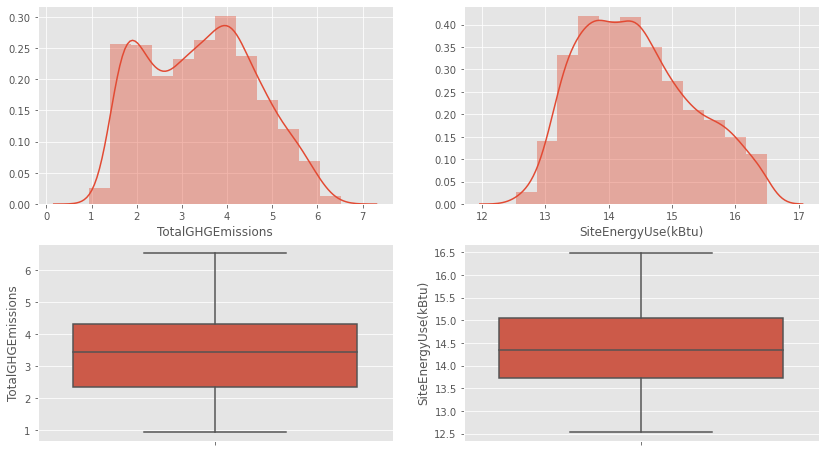

In [37]:
plt.style.use('ggplot')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(data))))
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label].apply(lambda x : np.log(1 + x)), orient="v")
plt.show()

In [38]:
print("Le nombre de bâtiments restant est de : {}".format(len(data)))

Le nombre de bâtiments restant est de : 3137


### 2.5 Variables énergétiques

In [39]:
# On récupère l'énergie totale et les emissions de CO2
TotalEnergyUse = data["SiteEnergyUse(kBtu)"]
TotalCO2 = data["TotalGHGEmissions"]

# On calcule les proportions de chaque source d'énergie 
data["Electricity"] = data["Electricity(kBtu)"]/data["SiteEnergyUse(kBtu)"]
data["NaturalGas"] = data["NaturalGas(kBtu)"]/data["SiteEnergyUse(kBtu)"]
data["SteamUse"] = data["SteamUse(kBtu)"]/data["SiteEnergyUse(kBtu)"]
data["OtherFuelUse"] = data["OtherFuelUse(kBtu)"]/data["SiteEnergyUse(kBtu)"]

In [40]:
# On supprime les colonnes renseignant les quantités d'énergie (kBtu et kWh) et de CO2 émis
col_to_del = []
for col in data :
    if ('kBtu' in col) or  ('kWh' in col) or ('CO2' in col) :
        col_to_del.append(col)
        
data.drop(columns=col_to_del, inplace=True)

# On récupère l'énergie totale et les emissions de CO2
data["SiteEnergyUse(kBtu)"] = TotalEnergyUse
data["TotalGHGEmissions"] = TotalCO2

In [41]:
print("Le nombre de bâtiments restant est de : {}".format(len(data)))

Le nombre de bâtiments restant est de : 3137


### 2.6 Corrélation entre variables

La matrice de corrélation permet de déterminer si certaines informations ne sont pas redondantes

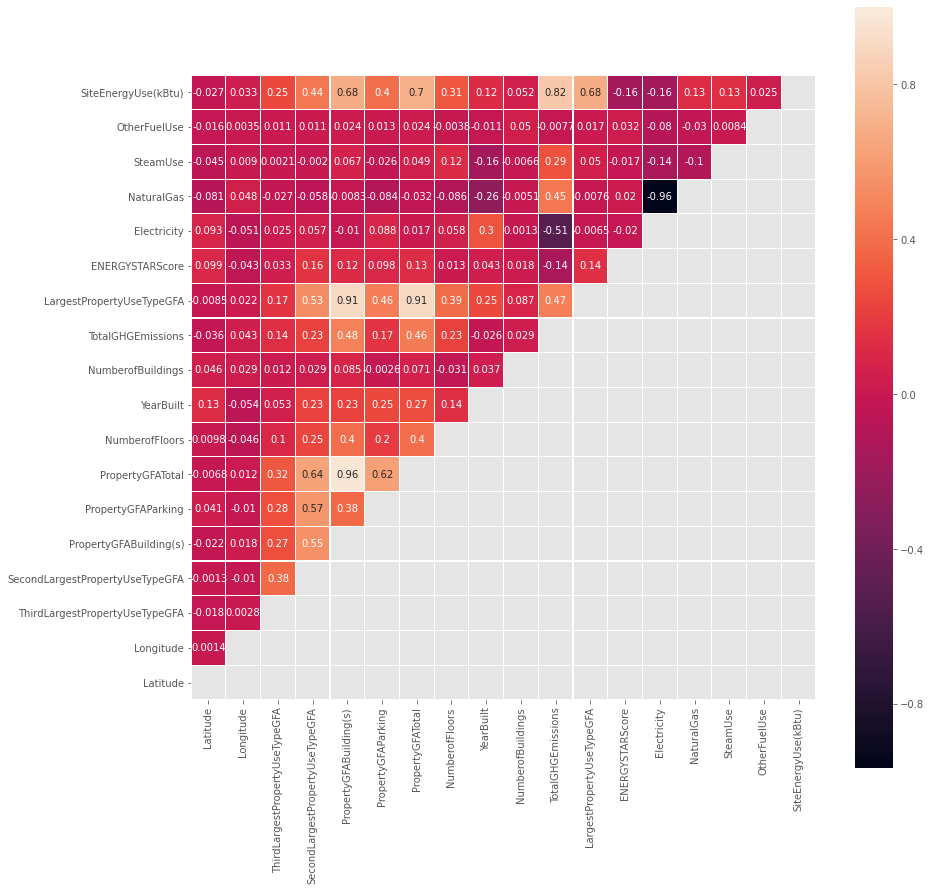

In [42]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(14, 14))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

- La consommation totale d'énergie est fortement corrélée à la surface des bâtiments
- Les émissions de Co2 sont fortement corrélées à la consommation totale d'énergie
- Les features 'LargestPropertyUseTypeGFA' et 'PropertyGFATotal' sont fortement corrrélées avec 'PropertyGFABuilding(s)' donc supprimées pour éviter la redondance d'informations

In [43]:
# Suppression des features 'LargestPropertyUseTypeGFA' et 'PropertyGFATotal'
data.drop(columns=['LargestPropertyUseTypeGFA', 'PropertyGFATotal'], inplace=True)

##### Matrice de corrélation après suppression de doublons d'informations

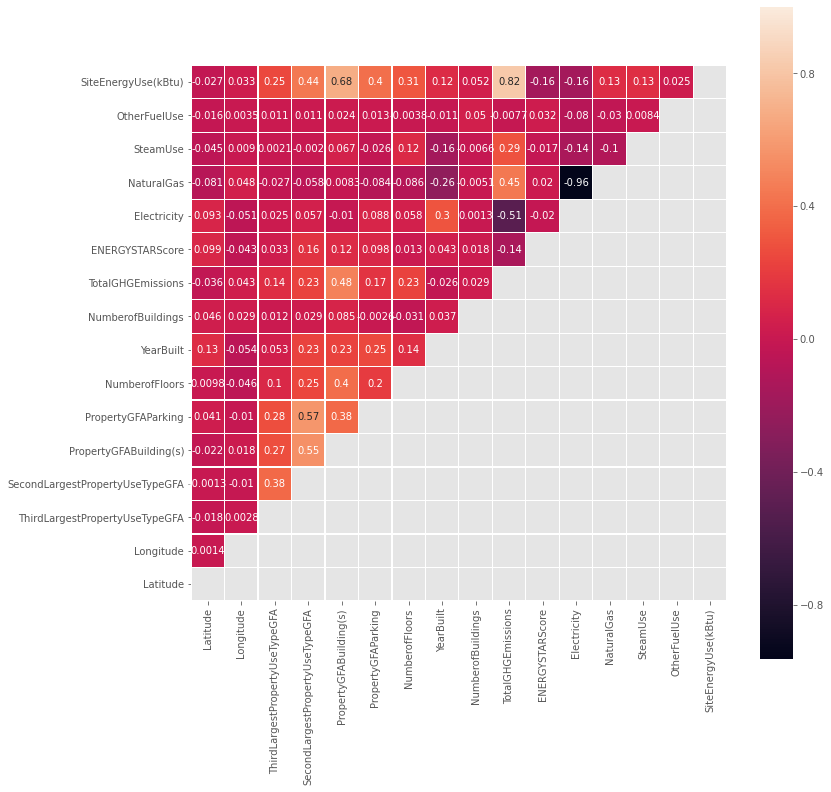

In [44]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(12, 12))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

## 3. Analyse des données

On récupère le nom des variables étiquettes ( à prédire), catégorielles et numériques

In [45]:
# Variables prédictives
y_labels = ["SiteEnergyUse(kBtu)",
            "TotalGHGEmissions",
            'Electricity',
            'NaturalGas',
            'SteamUse',
            "OtherFuelUse"]

# Variables catégorielles
cat_attribs = list(data.select_dtypes(include='object').columns)

# Variables numériques
num_attribs = list(data.drop(columns=cat_attribs + y_labels + ["ENERGYSTARScore"]).columns)

### 3.1 Géolocalisation des bâtiments

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\maleg\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\maleg\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\maleg\Anaconda3\lib\site-packages\pandas\plotting\_matpl

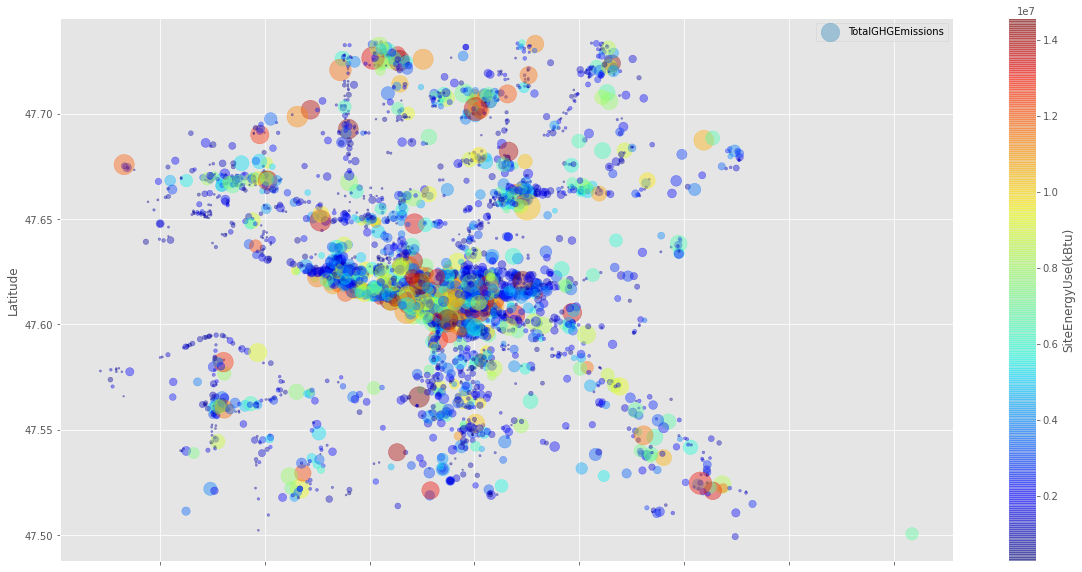

In [46]:
data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
            s=data["TotalGHGEmissions"], label="TotalGHGEmissions",
            c="SiteEnergyUse(kBtu)", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(20,10))
plt.show()

- Il y a une très forte densité de bâtiments au centre géographique

- Il y a quelques bâtiments outliers en consommation d'énergie totale

- Il n'y pas de séparation visuellement franche

### 3.2 Distribution des variables numériques

#### Variables indicatives (features)

C:\Users\maleg\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\maleg\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\maleg\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\maleg\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\maleg\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\maleg\AppData\Roamin

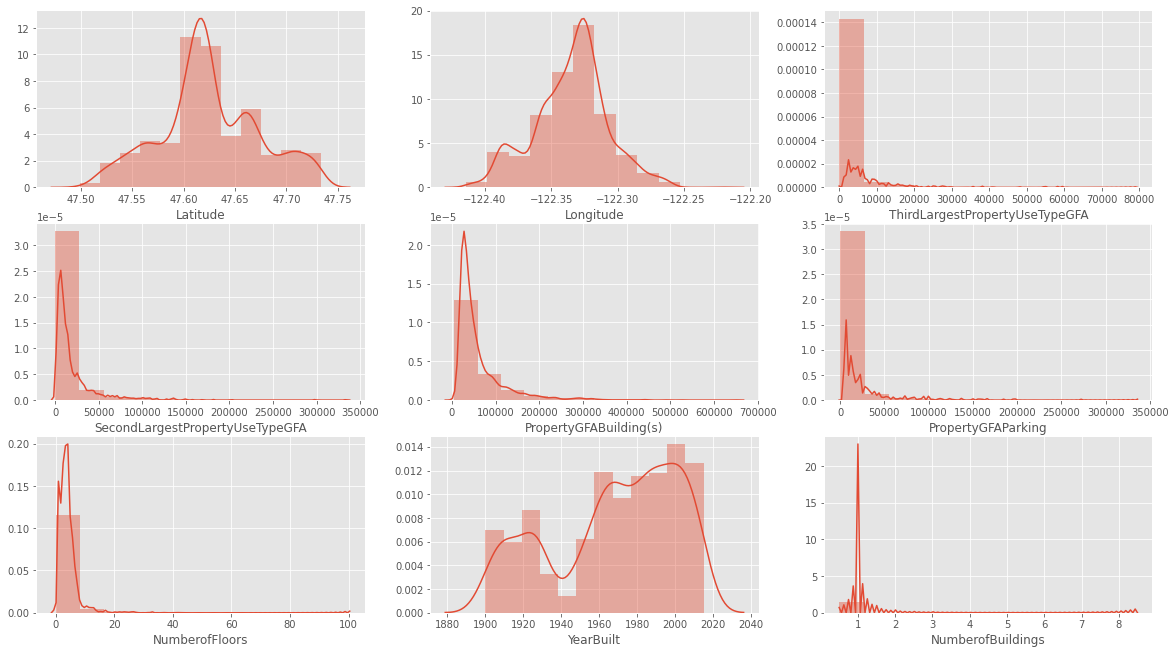

In [47]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize=(20, 15))
for i, label in enumerate(num_attribs) :
    plt.subplot(4, 3, i + 1)
    sns.distplot(data[label], bins=int(1 + np.log2(len(data))))
plt.show()

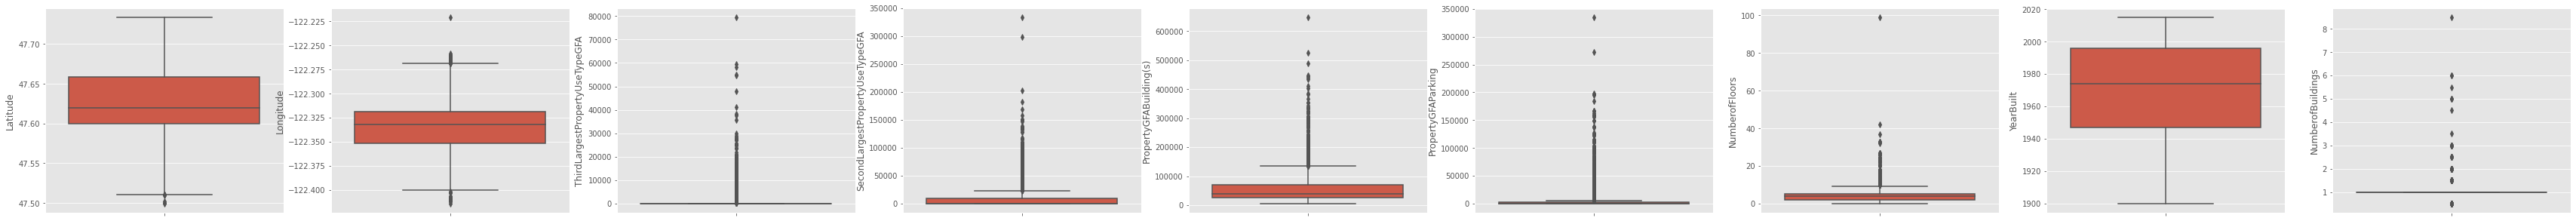

In [48]:
fig = plt.figure(1, figsize=(60, 5))
for i,label in enumerate(num_attribs) :
    plt.subplot(1,len(num_attribs), i+1)
    sns.boxplot(data[label], orient="v")
plt.show()

- Les bâtiments les plus anciens ont été construits en 1900 et les plus récents en 2015
- La distribution de 'NumberofFloors' indique la présence de bâtiments plain-pieds aux gratte ciels
- La plus part des individus (au sens statistique du terme) de notre échantillon de données présentent un seul bâtiment
- La médianne et la valeur la plus fréquente pour le nombre d'étages est de 4

#### Variables à prédire

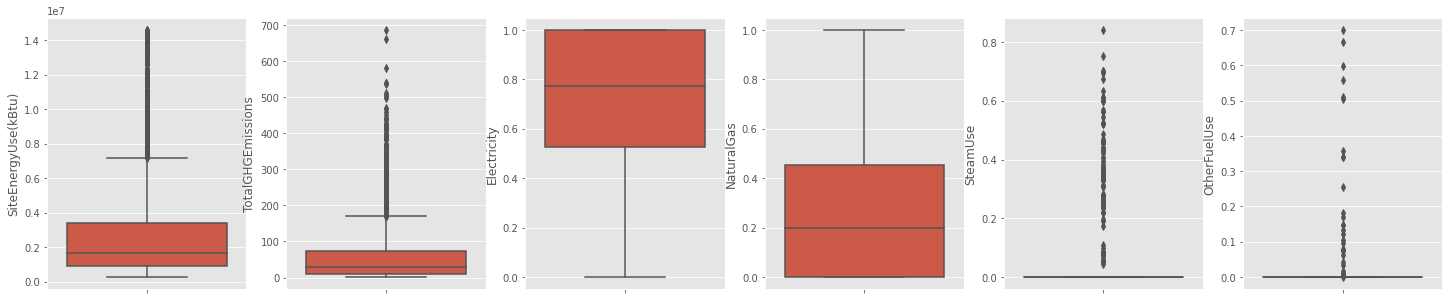

In [49]:
fig = plt.figure(1, figsize=(25, 5))
for i,label in enumerate(y_labels) :
    plt.subplot(int("1" + str(len(y_labels)) + str(i+1)))
    sns.boxplot(data[label], orient="v")
plt.show()

- La plus part des bâtiments ont une consommation de "SteamUse" quasi nulle, la balance énergétique se fait entre l'électricité et le gas naturel, et avec la 'Steam' pour quelques bâtiments

- Certains bâtiments sont des outliers en consommation d'énergie, ils sont trop peu nombreux à avoir une consommation supérieur à 1e8 kBtu

### 3.3 Variables catégorielles

Nombre de valeurs différentes pour chaque variable catégorielle

In [50]:
obj_columns = list(data.select_dtypes(include=['object', 'bool']).columns)
for cat in data[obj_columns]:
    print(cat, " :", data[cat].nunique())

BuildingType  : 8
PrimaryPropertyType  : 26
ComplianceStatus  : 4
CouncilDistrictCode  : 7
Neighborhood  : 19
SecondLargestPropertyUseType  : 50
DefaultData  : 4
ThirdLargestPropertyUseType  : 39
ListOfAllPropertyUseTypes  : 409
LargestPropertyUseType  : 54


Convertie en majuscule toutes les chaines de caractère

In [51]:
# Pour chaque variable catégorielle, met en majuscules toutes les valeurs
for cat in data[obj_columns]:
    data[cat] = data[cat].apply(lambda x: str(x).upper())

Distribution des valeurs pour chaque variable catégorielle

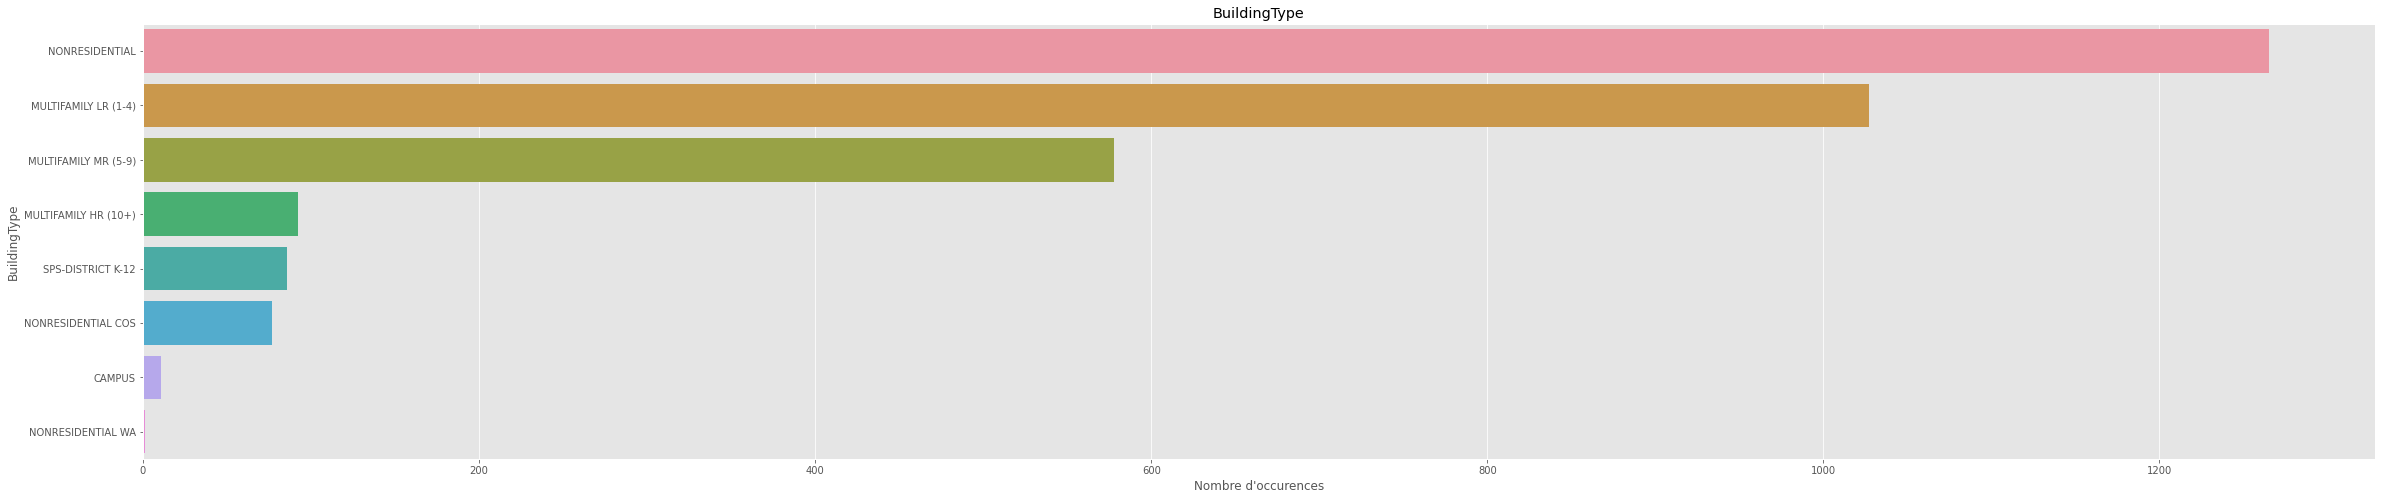

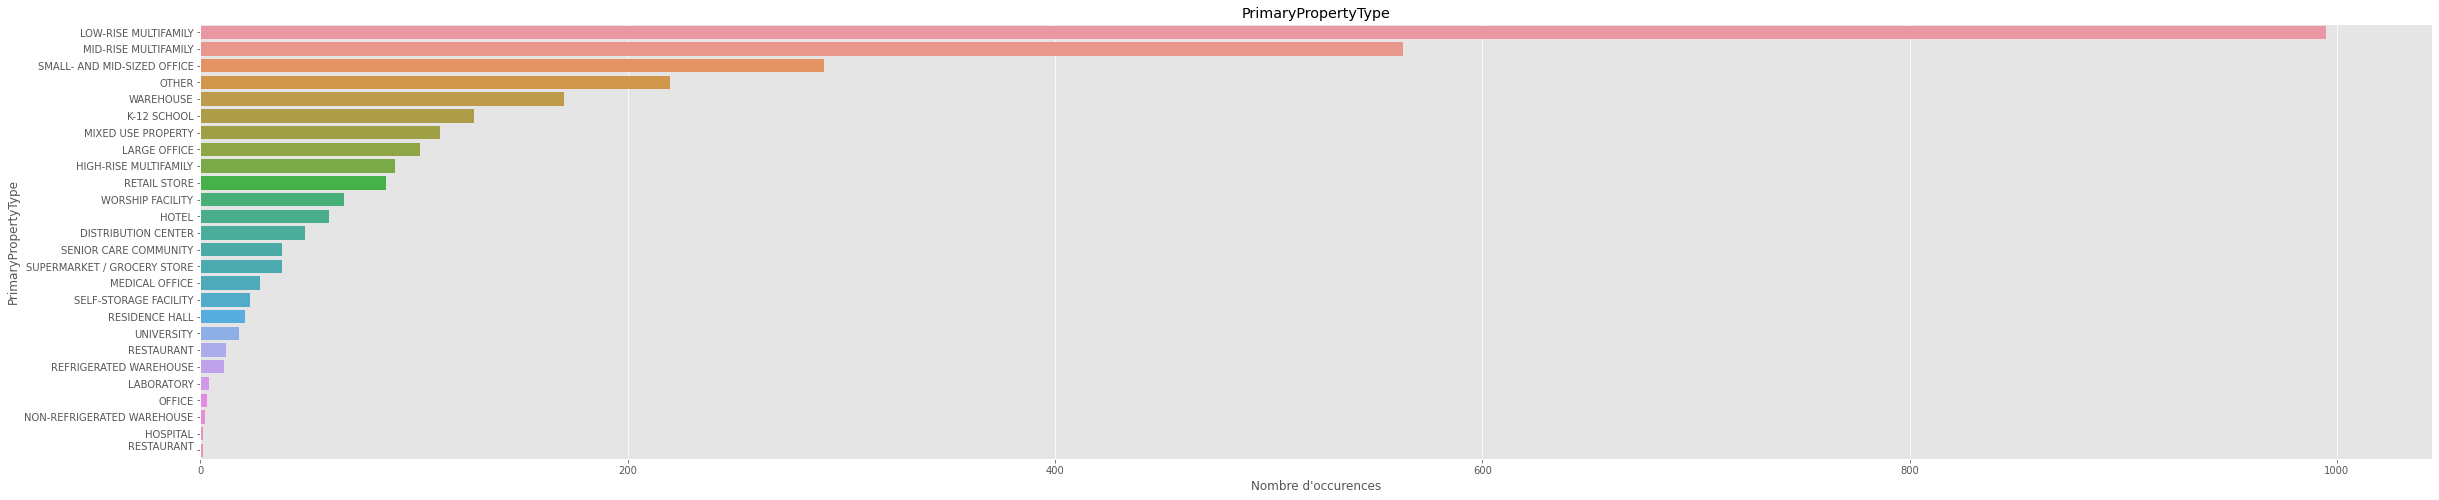

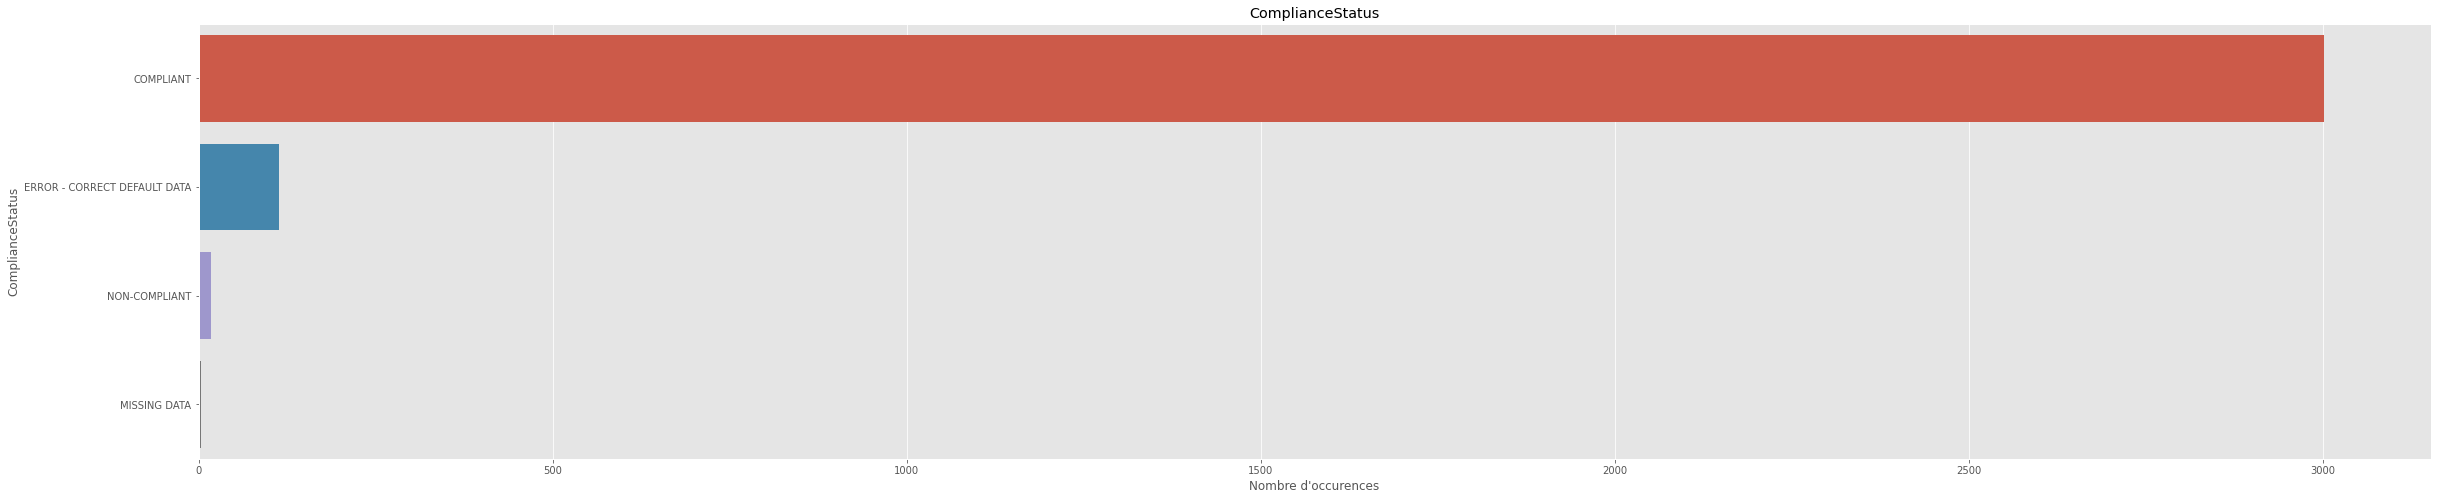

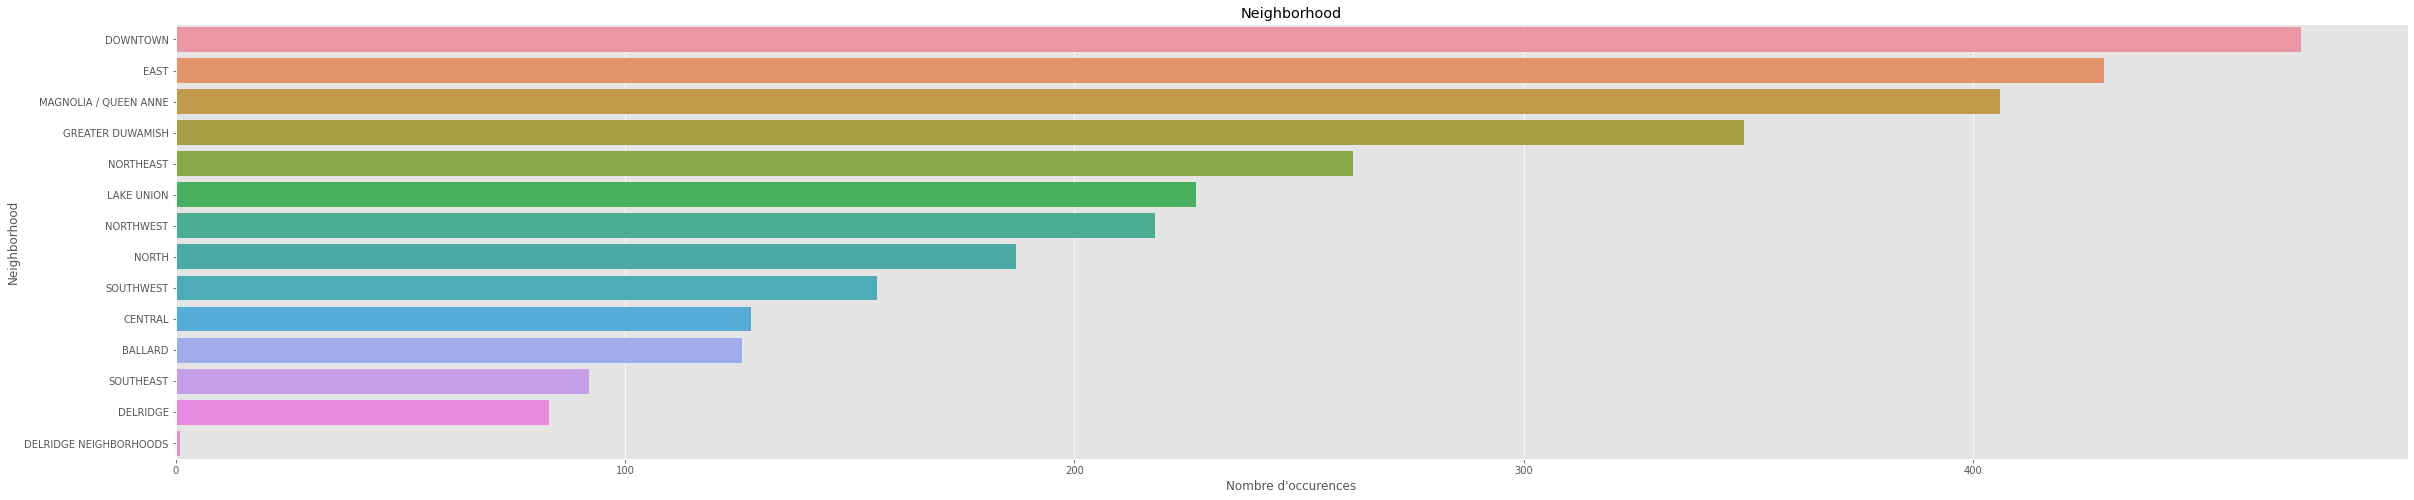

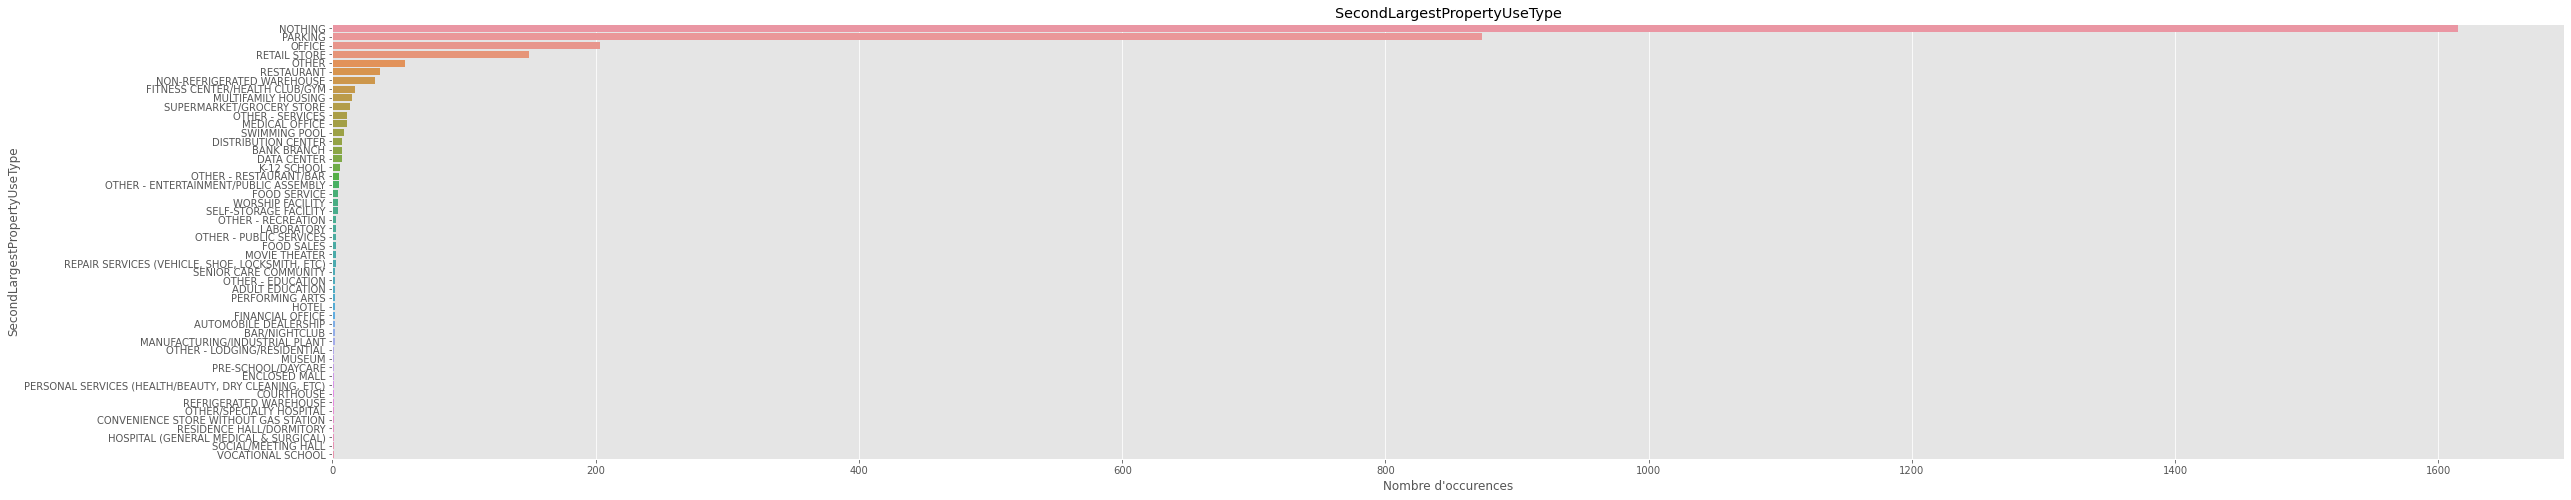

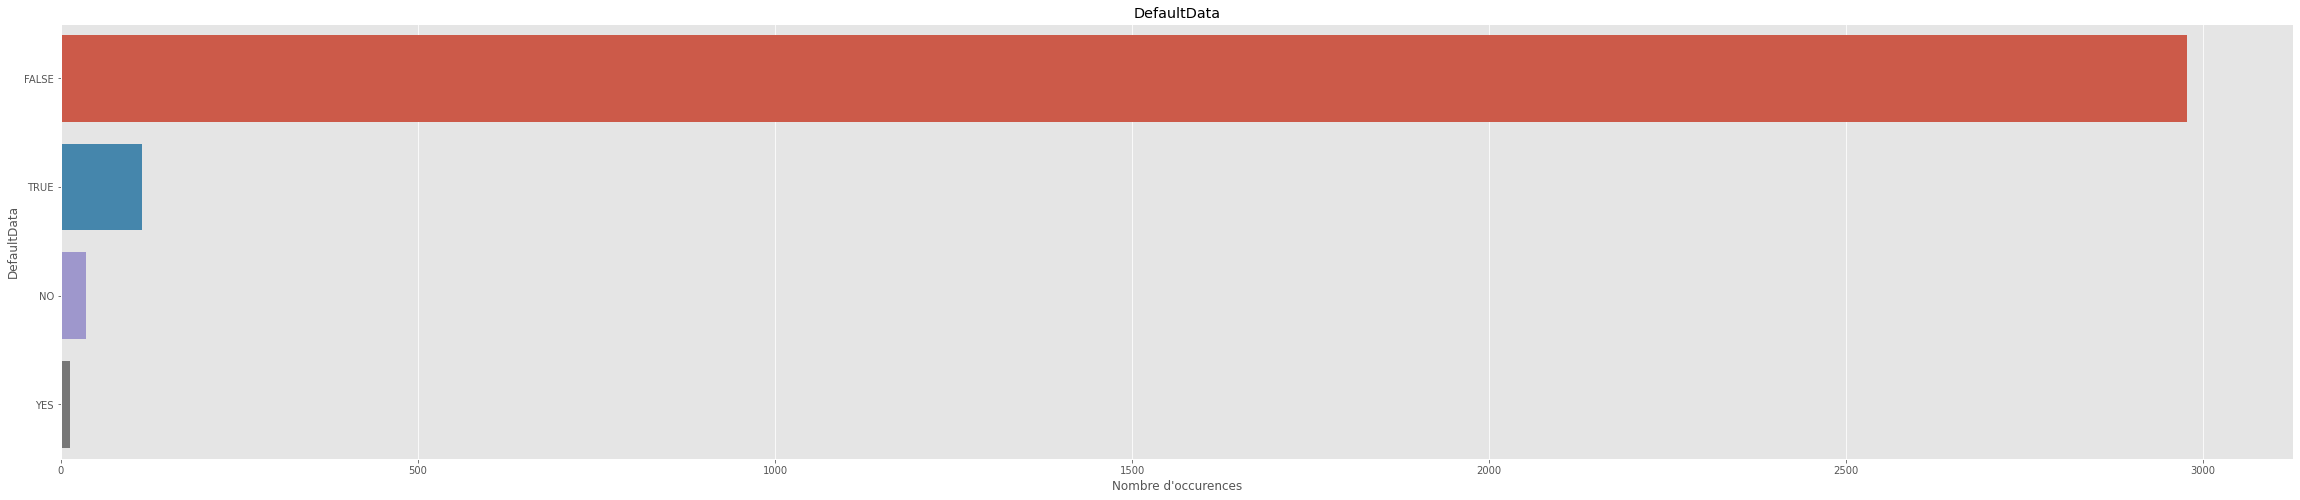

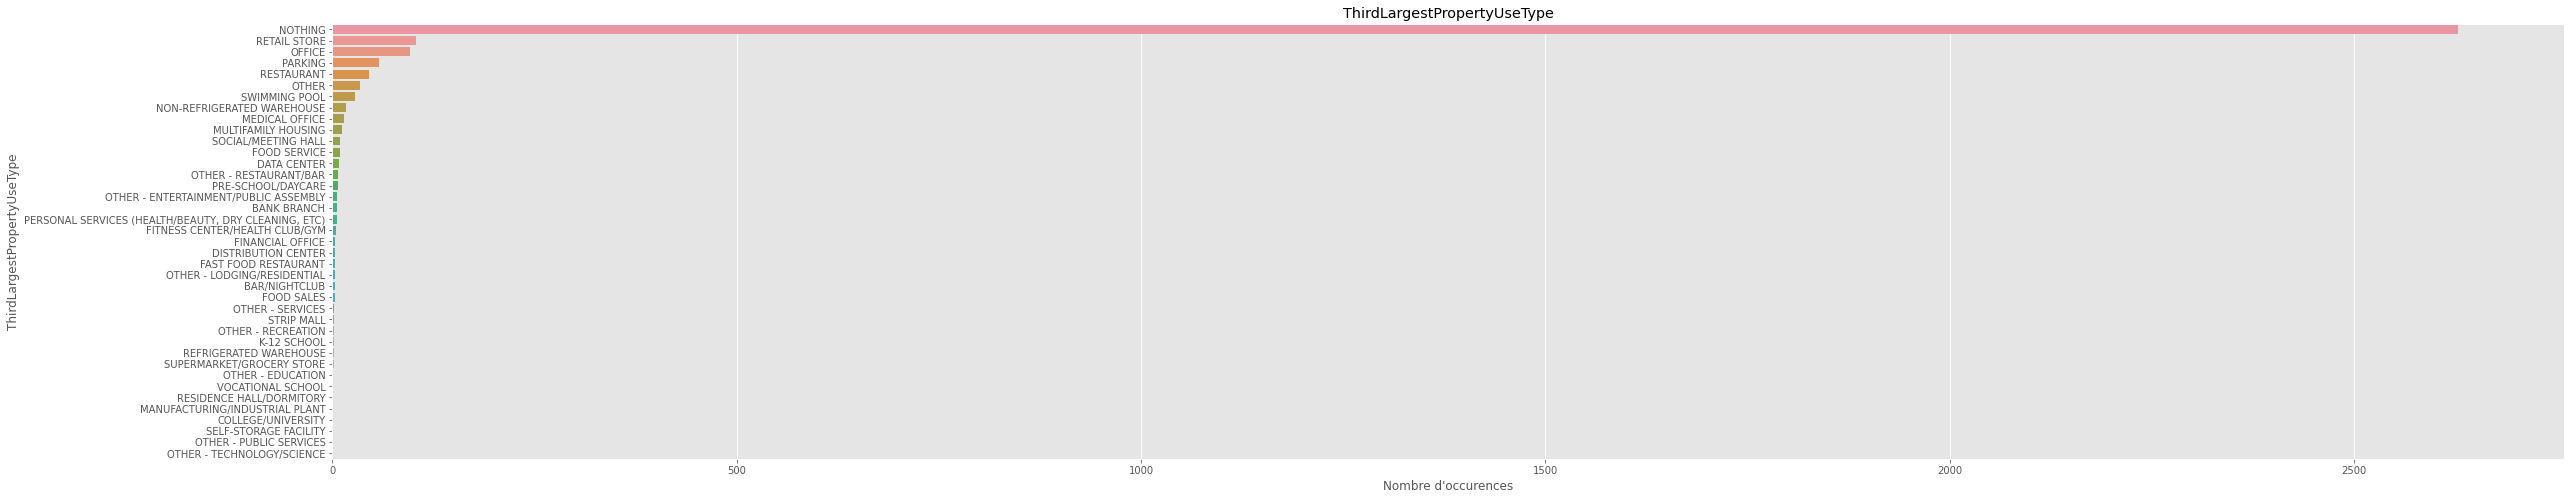

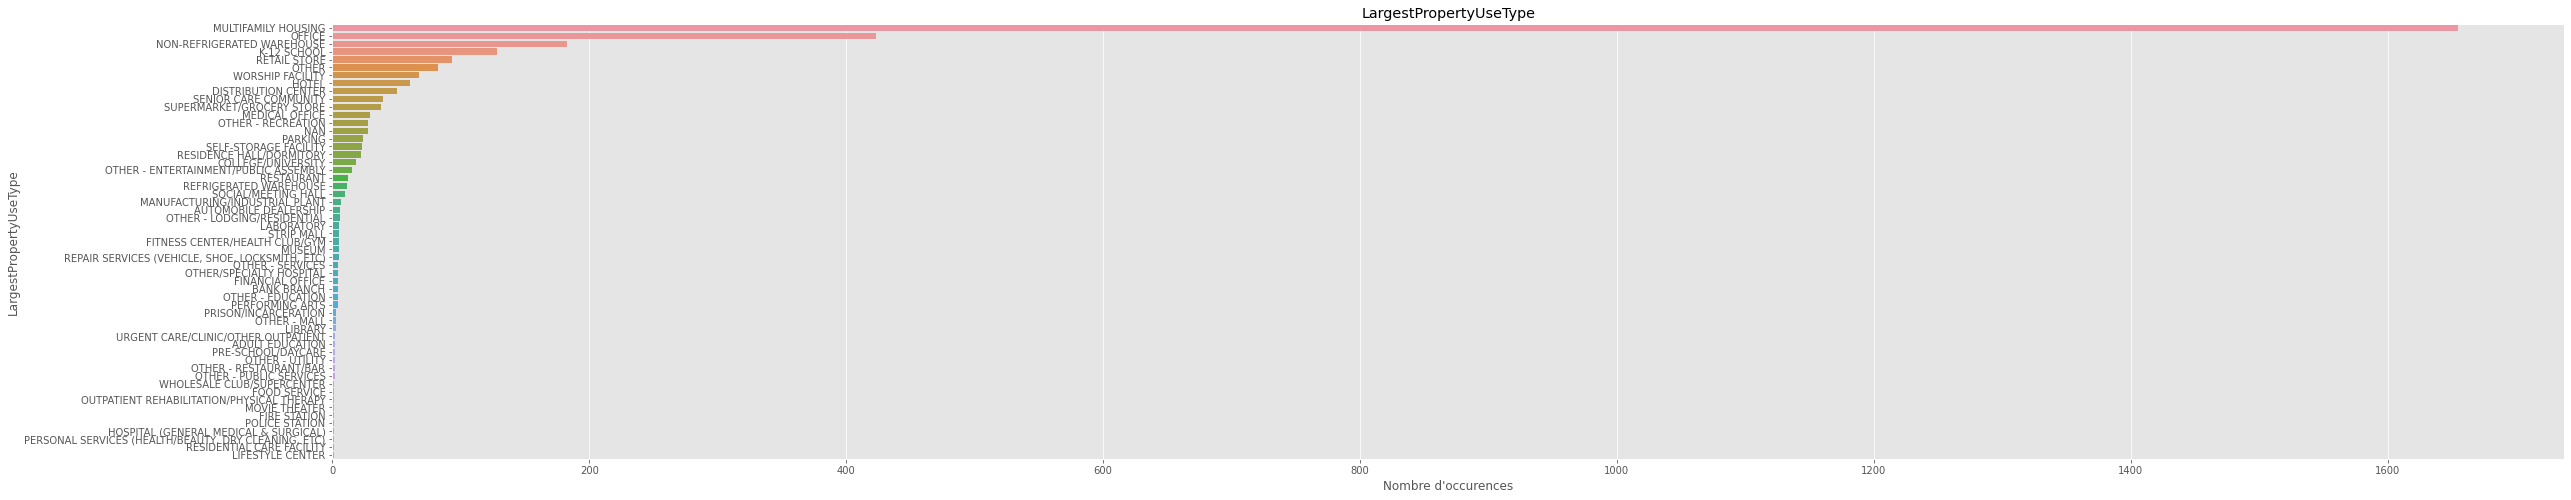

In [52]:
# Toutes les variables catégorielles sauf "ListOfAllPropertyUseTypes" et "LargestPropertyUseType"
cat_attribs_to_plot = list(data[cat_attribs].drop(columns=["ListOfAllPropertyUseTypes",
                                                          'CouncilDistrictCode']).columns)

for cat in cat_attribs_to_plot :
    fig = plt.figure(1, figsize=(40 ,8))
    data[cat] = data[cat].str.upper()
    df_cat = data[cat].value_counts()
    plt.title(cat)
    plt.ylabel(cat)
    plt.xlabel("Nombre d'occurences")
    sns.barplot(df_cat.values, df_cat.index)
    plt.show()

#### Variable DefaultData

In [53]:
# Renommage de certaines valeurs
# 'No' est converti en False et 'Yes' en True
data.loc[data["DefaultData"] == True, "DefaultData"] = 'Yes'
data.loc[data["DefaultData"] == False, "DefaultData"] = 'No'

#### Boxplot de la colonne 'PrimaryPropertyType'

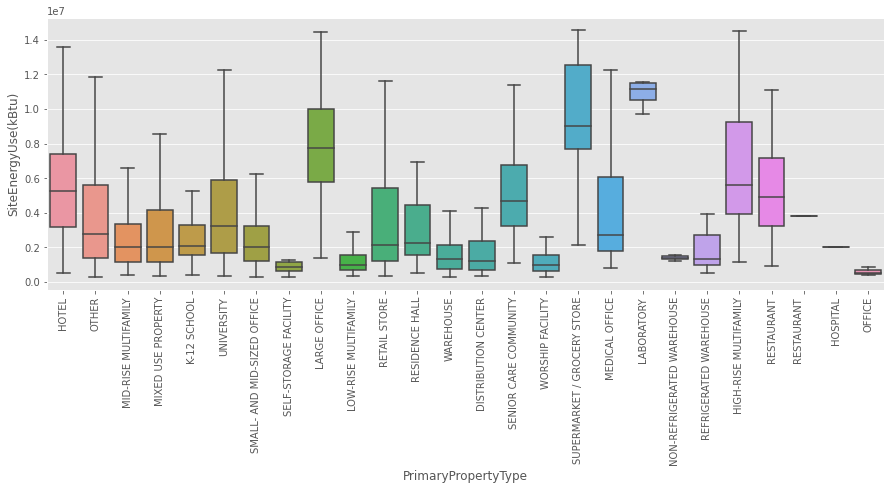

In [54]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=data, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)", showfliers=False)
plt.xticks(rotation=90)
plt.show()

Nombre de valeurs par type de bâtiments

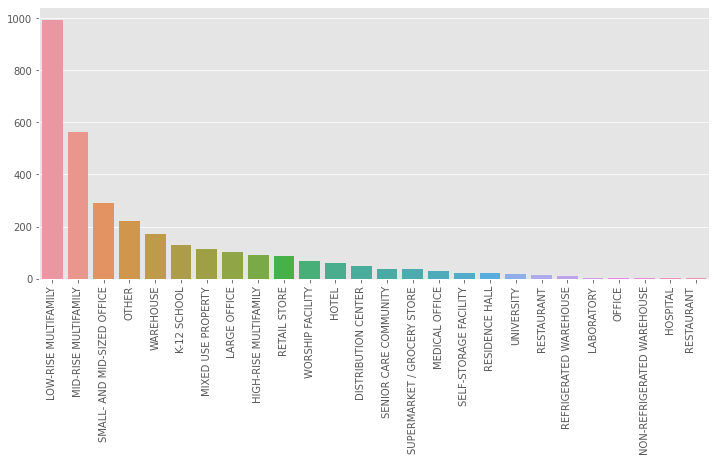

In [55]:
fig = plt.figure(1, figsize=(12, 5))
Nb_buildingTypes = data["PrimaryPropertyType"].value_counts()
sns.barplot(x=Nb_buildingTypes.index, y = Nb_buildingTypes.values)
plt.xticks(rotation=90)
plt.show()

In [56]:
# Nombre d'occurences par 'PrimaryPropertyType'
data["PrimaryPropertyType"].value_counts()

LOW-RISE MULTIFAMILY           995
MID-RISE MULTIFAMILY           563
SMALL- AND MID-SIZED OFFICE    292
OTHER                          220
WAREHOUSE                      170
K-12 SCHOOL                    128
MIXED USE PROPERTY             112
LARGE OFFICE                   103
HIGH-RISE MULTIFAMILY           91
RETAIL STORE                    87
WORSHIP FACILITY                67
HOTEL                           60
DISTRIBUTION CENTER             49
SENIOR CARE COMMUNITY           38
SUPERMARKET / GROCERY STORE     38
MEDICAL OFFICE                  28
SELF-STORAGE FACILITY           23
RESIDENCE HALL                  21
UNIVERSITY                      18
RESTAURANT                      12
REFRIGERATED WAREHOUSE          11
LABORATORY                       4
OFFICE                           3
NON-REFRIGERATED WAREHOUSE       2
HOSPITAL                         1
RESTAURANT\n                     1
Name: PrimaryPropertyType, dtype: int64

In [58]:
# Renommage de la valeur 'RESTAURANT\n' en 'RESTAURANT'
data.loc[data["PrimaryPropertyType"] == "RESTAURANT\n", "PrimaryPropertyType"] = "RESTAURANT"

In [59]:
# Suppresion des bâtiments de type Hospital
data = data.loc[~data["PrimaryPropertyType"].isin(["HOSPITAL"])]

Le bâtiment de type 'Hospital' est présent 1 seule fois dans le jeu de données donc supprimé

#### Sauvegarde des données

In [60]:
# Sauvegarde des données en .csv
data.to_csv("data_clean.csv")

## 4. Préparation des données

#### Transformation logarithmiques des variables à prédire

In [61]:
data.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]] = data.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]].apply(lambda x: np.log(1 + x))

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Liste des variables catégorielles et numériques

In [62]:
# Variables catégorielles
cat_attribs = list(data.select_dtypes(include=['object']).columns)

# Variables numériques
num_attribs = list(data.drop(columns=cat_attribs + y_labels + ["ENERGYSTARScore"]).columns)

# Liste des types d'énergie
list_energy_type = ["Electricity",
                    "NaturalGas",
                    "SteamUse",
                    "OtherFuelUse"]

### 4.1 Feature Engineering
- Surface totale = Surface au sol * Nombre d'étages

In [68]:
PropertyGFABuilding_ix, NumberofFloors_ix = 4, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin) :
    
    def __init__(self, add_GFA_per_floor_per_building=True) :
        self.add_GFA_per_floor_per_building = add_GFA_per_floor_per_building
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_GFA_per_floor_per_building :
            BuildingGFA_per_floor = X[:, PropertyGFABuilding_ix]*X[:, NumberofFloors_ix]
            return np.c_[X, BuildingGFA_per_floor]
        else : 
            return X 

- Variables booléennes des energies

In [69]:
class AddBooleanEnergyType(BaseEstimator, TransformerMixin) :
    
    def __init__(self, add_Boolean_EnergyType=True) :
        self.add_Boolean_EnergyType = add_Boolean_EnergyType
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_Boolean_EnergyType :
            
            return np.array(X > 0) * 1
        else : 
            return X 

### 4.2 Pipelines numériques et catégorielles

##### Target Encoding
Les variables catégorielles sont transformés par un target_encoder.

Le target encoding consiste à remplacer la valeur de chaque variable catégorielle par la moyenne de la cible des individus ayant la même valeur pour la variable catégorielle

##### Standard Scaler

<img src="std.png">

#### Définition des pipelines

In [327]:
# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ('attribs_combined', CombinedAttributesAdder()), # Feature engineering
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ])

# Pipeline pour les variables booléennes
add_bool_pipeline = Pipeline([
    ('bool_energy', AddBooleanEnergyType()) # Les types sont converties en variables booléennes
])

In [328]:
# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("energyType", add_bool_pipeline, list_energy_type),
        ("cat", cat_pipeline, cat_attribs),
    ])

### 4.3 Séparation du jeu de données en jeu d'entrainement et de test

#### Séparation 80% entrainement, 20% test

In [72]:
# Split en jeu d'entrainement et de test
train_set, test_set = train_test_split(data, train_size=0.8, random_state=0)

### 4.4 Sélection des étiquettes

In [73]:
# Variables targets
y_labels = ["SiteEnergyUse(kBtu)",
            "TotalGHGEmissions",
            'Electricity',
            'NaturalGas',
            'SteamUse',
            "OtherFuelUse"]

## 5. Sélection et entrainement de modèles

#### Méthodologie :

Ce projet se porte sur la prédiction de deux variables, la consommation d'énergie et les émissions de Co2.

Nous allons procéder ainsi :

1) La consommation d'énergie totale est prédite en utilisant l'ensemble des variables à notre disposition ainsi que les variables booléans renseignant les types d'énergie utilisés par la structure. Par exemple, si un bâtiment utilise comme source d'énergie l'électricité, la valeur 1 est attribué sinon 0, ainsi de suite pour tous les types d'énergie
    
2) La proportion utilisé de chaque type d'énergie est prédite (en utilisant également les variables booléennes)
    
3) Les émissions de Co2 sont prédites en utilisant les variables propres au bâtiment, ainsi que la prédiction de la consommation d'énergie totale et la proportion de chaque type d'énergie

#### Métriques

Dans cette partie, deux métriques sont utilisés : la MAE et la RMSE

La RMSE est plus sensible que la MAE aux valeurs s'écartant de la normale, ce qui permet de mieux traiter les écarts importants, c'est pourquoi la RMSE est préféré et sera utilisé pour la séléction des modèles finaux. En revanche la MAE sert à titre indicatif

<img src="rmse.png">

- ŷi : valeur prédite
- yi : valeure réelle

Une autre métrique est utilisé en complément pour avoir une idée plus parlante de la qualité d'un modèle, il s'agit du coefficient de détermination qui s'exprime de la manière suivante :


<img src="r2.png">

R² varie entre -1 et 1. Plus il est proche de 1 et plus les valeurs prédites et réelles sont corrélés

In [ ]:
# Distribution des indices train/validation pour obtenir des jeux train/validation.
# Divise le jeu de données en k partitions
kf = KFold(n_splits=5)

In [75]:
# Dictionnaires de résultats
y_pred = {}
rmse = {}
mae = {}
final_model = {}

In [76]:
def display_scores(scores, scoring=["neg_mean_squared_error", "neg_mean_absolute_error"]) :
    # Résultats, moyenne et écart-type

    print("Resultats de la cross validation :")
     
    for metric in scoring : 
    
        results = -scores["test_" + metric]
        if metric == "neg_mean_squared_error" :
            print("Métrique utilisé : RMSE")
            results = np.sqrt(results)
        else :
            print("Métrique utilisé : MAE")
        print("\t - Moyenne : {:.3f}".format(results.mean()))
        print("\t - Ecart-type : {:.3f}".format(results.std()))
        print("\t - Coefficient de variation : {:.2f} %".format(results.std()/results.mean()*100))
        print("\n")

In [77]:
def mean_absolute_percentage_error(y_true, y_pred): 
    # MAPE : Mean aboslute percentage error

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [78]:
def define_pipeline(preprocessor, regressor) :
    # Assembly of preprocessor and regressor
    pipe = Pipeline([("preprocess", preprocessor),
                    ("regressor", regressor),
                    ])
    return pipe

In [79]:
# Fonction qui permet d'afficher un barplot des résultats : moyenne, écart-type et coefficient de variation
def graphical_display(results, title) :
    
    x = list(results)
    y = np.array(list(results.values()))
    rmse_mean = [score.mean() for score in np.array(list(results.values()))]
    rmse_std = [score.std() for score in np.array(list(results.values()))]
    
    # Liste des couleurs pour chaque segment
    palette = sns.color_palette()
    colors = palette.as_hex()[0: len(results)]

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,5))
    fig.suptitle(title, fontsize=18)
    # Barplot de la moyenne et son ecart-type
    axs[0].bar(x=x, height=rmse_mean, color=colors)
    axs[0].set_ylabel("Mean")
    # Ajout de la barre ecart-type
    axs[0].errorbar(range(len(rmse_mean)), rmse_mean, yerr=rmse_std, fmt='none', ecolor='black')
    # Titre du graphique
    axs[1].bar(x=x, height=rmse_std, color=colors)
    axs[1].set_ylabel("Variance")

    plt.show()

### 5.1 Prédiction de l'énergie totale

#### 5.1.1 Modèle Quick & Dirty

In [80]:
# Dictionnaire de regresseurs
regressors = {                   
                   'Dummy': DummyRegressor(),
                   'Elastic Net' : ElasticNet(max_iter=1000),
                   'SVR': SVR(kernel="rbf", C=300, gamma=1),
                   'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1),
                   'Extra Tree': ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
                   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
                  }

In [ ]:
# Les regressors sont testés 1 à 1 par cross-validation
for name_reg, reg in regressors.items() :
    print("_____", name_reg, "_____")
    
    pipeline = define_pipeline(full_pipeline, reg) 
    # cross-validation
    scores = cross_validate(pipeline,
                            train_set,
                            train_set["SiteEnergyUse(kBtu)"],
                            scoring=["neg_mean_squared_error",
                                     "neg_mean_absolute_error"],
                            cv=kf)
    # calcul de la RMSE
    rmse[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])
    # calcul de la MAE
    mae[name_reg] = -scores["test_neg_mean_absolute_error"]

    # Affichage des résultats
    display_scores(scores,
                   scoring = ["neg_mean_squared_error",
                              "neg_mean_absolute_error"])
    
# Affichage des résultats de la RMSE
graphical_display(rmse, "RMSE issue de la cross-validation pour la prédiction de l'énergie totale")

# Affichage des résultats de la MAE
graphical_display(mae, "MAE issue de la cross-validation pour la prédiction de l'énergie totale")

- 3 Modèles se démarquent des autres et offrent sensiblement les mêmes résultats, il s'agit de :
 #### Random Forest, Gradient de boosting,  Extra Tree

Dans la partie qui suit, nous cherchons à hyper-paramétriser ces 3 modèles dans le but d'affiner les résultats

#### 5.1.8 Réglage du meilleur modèle

In [84]:
# Dictionnaire des Random Search pour conserver tous les résultats
rnd_search_results = {}

In [427]:
def rnd_search(regressors, pipeline, param_grid, X, y, n_splits=5, display=True) :
    
    """
    Optimise une liste d'estimateurs et retourne le meilleur
    regressors(dict): Dictionnaire d'estimateurs, {"name_estimator_1" : estimator_1}
    pipeline : pipeline de transformation de données
    param_grid(dict) : dictionnaire de dictionnaires de paramètres, {"name_estimator_1": dict_params}
    X(np.array): jeux de données
    y(np.array): prédiction
    
    
    """
    
    # Distribution des indices train/validation pour obtenir des jeux train/validation.
    # Divise le jeu de données en k partitions
    kf = KFold(n_splits=n_splits)
    
    rnd_search_dict = {}
    
    # Meilleur score
    best_score = float('inf')
    # Dictionnaire des modèles hyperparamétrés
    rmse_mean, rmse_std = {}, {}
    fit_time_mean, fit_time_std = {}, {}

    for name_reg, regressor in regressors.items() :
    
        print(name_reg)
        prepare_select_and_predict_pipeline = define_pipeline(pipeline, regressor)

    
        rnd_search_prep = RandomizedSearchCV(prepare_select_and_predict_pipeline,
                                             param_grid[name_reg],
                                             n_iter=100,
                                             scoring='neg_mean_squared_error',
                                             cv=kf,
                                             random_state=42)
        
        # Entrainement du modèle
        rnd_search_prep.fit(X, y)
        
        # Sauvegarde du modèle
        rnd_search_dict[name_reg] = rnd_search_prep
        
        best_model_index = rnd_search_prep.best_index_
        score = [np.sqrt(-rnd_search_prep.cv_results_["split" + str(i) + "_test_score"][best_model_index])
                 for i in range(n_splits)]
        
        # Temp d'entrainement du modèle
        fit_time_mean[name_reg] = rnd_search_prep.cv_results_['mean_fit_time'][best_model_index]
        fit_time_std[name_reg] = rnd_search_prep.cv_results_['std_fit_time'][best_model_index]
        
        # Moyenne et écart-type de la RMSE
        mean_score, std_score = np.mean(score), np.std(score)
        rmse_mean[name_reg], rmse_std[name_reg] = mean_score, std_score
        score = rnd_search_prep.best_estimator_.score(X, y)
        
        print("Paramètres du meilleur modèle : \n")
        for params, values in rnd_search_prep.best_params_.items():
             print("\t - ", params, ":", values)
        print("\nRésultats :")
        print("\n\t - r2 score sur le jeu d'entrainement : {:.3f}".format(score))
        print("\t - Mean of RMSE : {:.3f}".format(mean_score))
        print("\t - Ecart-type : {:.3f}".format(std_score))
        print("\t - Coefficient de variation : {:.2f} % \n".format(std_score/mean_score*100))
        
        if mean_score < best_score :
            best_score = mean_score
            best_model = rnd_search_prep.best_estimator_
            
    if display:
            
        # Liste des couleurs pour chaque segment
        palette = sns.color_palette()
        colors = palette.as_hex()[0: len(regressors_2)]

        # Graphique des résultats pour la RMSE de l'hyper-paramétrisation
        fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 5))
        fig.suptitle("RMSE sur les jeux de validation", fontsize=18)

        axs[0].set_ylabel("Mean of RMSE", fontsize=13)
        axs[0].bar(x=list(rmse_mean.keys()), height=list(rmse_mean.values()), color=colors)
        axs[0].errorbar(range(len(rmse_mean)), rmse_mean.values(), yerr=rmse_std.values(), fmt='none', ecolor='black')
        axs[0].tick_params(axis='x', labelsize=13)

        axs[1].set_ylabel("Variance of RMSE", fontsize=13)
        axs[1].bar(x=list(rmse_std.keys()), height=list(rmse_std.values()), color=colors)
        axs[1].tick_params(axis='x', labelsize=13)
        plt.show()

        # Graphique des résultats pour la RMSE de l'hyper-paramétrisation
        fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 5))
        fig.suptitle("Temps d'entrainement des modèles", fontsize=18)

        axs[0].set_ylabel("Mean of Fit Time (s)", fontsize=13)
        axs[0].bar(x=list(fit_time_mean.keys()), height=list(fit_time_mean.values()), color=colors)
        axs[0].errorbar(range(len(fit_time_mean)), fit_time_mean.values(), yerr=fit_time_std.values(), fmt='none', ecolor='black')
        axs[0].tick_params(axis='x', labelsize=13)


        axs[1].set_ylabel("Variance of Fit Time (s)", size=13)
        axs[1].bar(x=list(fit_time_std.keys()), height=list(fit_time_std.values()), color=colors)
        axs[1].tick_params(axis='x', labelsize=13)
        plt.show()
        
            
    return rnd_search_dict

In [86]:
# Modèles à hyper-paramétriser
regressors_2 = {
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'Random Forest': RandomForestRegressor(random_state=42),
                'Extra Forest': ExtraTreesRegressor(random_state=42)   
}

In [87]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'preprocess__num__imputer__strategy': ['mean', 'median'],# Méthode d'imputation des variables numériques
    'preprocess__cat__imputer__strategy': ['mean', 'median', 'most_frequent'], # Méthode d'imputation des variables catégorielles
    'regressor__n_estimators': [100], # Nombre d'arbres
    'regressor__max_depth': range(2, 20, 2), # Nombre de profondeurs maximums
    'regressor__max_features': range(2, 20, 2) # Nombre de maximum de features
}

# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__learning_rate"] = [0.01, 0.05, 0.1]
param_grid_gb["regressor__n_estimators"] = [50, 100, 300]

# Dictionnaire de grille de paramètres
param_grid = {'Gradient Boosting': param_grid_gb,
              'Random Forest': param_grid_reg_tree,
              'Extra Forest': param_grid_reg_tree,
             }

Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 300
	 -  regressor__max_features : 6
	 -  regressor__max_depth : 4
	 -  regressor__learning_rate : 0.05
	 -  preprocess__num__imputer__strategy : mean
	 -  preprocess__cat__imputer__strategy : median

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.878
	 - Mean of RMSE : 0.449
	 - Ecart-type : 0.011
	 - Coefficient de variation : 2.45 % 

Random Forest
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 4
	 -  regressor__max_depth : 18
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strategy : mean

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.959
	 - Mean of RMSE : 0.453
	 - Ecart-type : 0.009
	 - Coefficient de variation : 2.05 % 

Extra Forest
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 16
	 -  regressor__max_depth : 16
	 -  preprocess__num__imputer

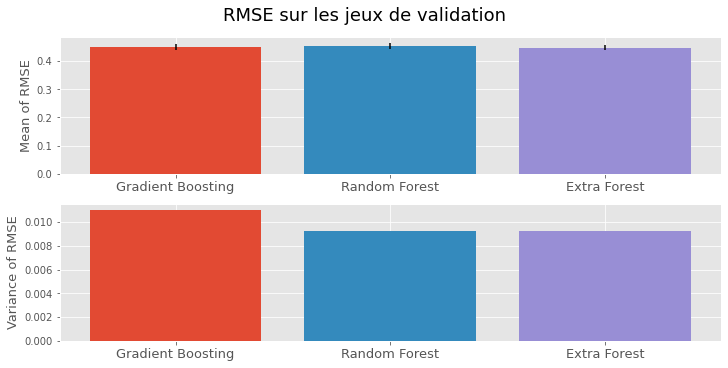

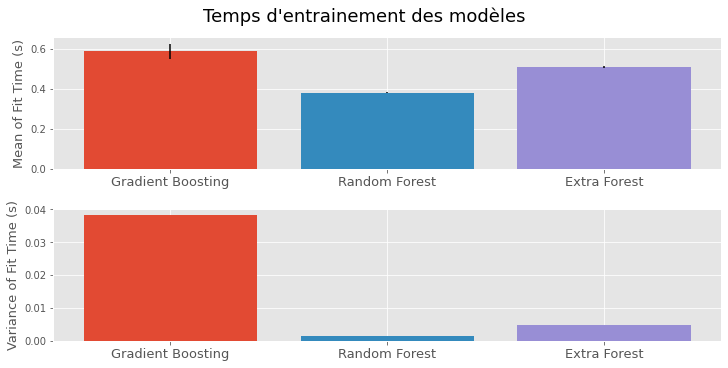

In [88]:
# Selection du meilleur modèle
rnd_search_results["SiteEnergyUse(kBtu)"] = rnd_search(regressors_2, 
                                               full_pipeline,
                                               param_grid,
                                               train_set,
                                               train_set["SiteEnergyUse(kBtu)"])

In [456]:
final_model["SiteEnergyUse(kBtu)"] = rnd_search_results["SiteEnergyUse(kBtu)"]['Extra Forest'].best_estimator_

Le modèle Extra Forest est celui qui donne les meilleurs résultats en terme de RMSE alors que son temps d'entrainement est similaire aux autres.

### 5.2 Prédiction proportions d'énergie

#### Hyperparamétrisation des modèles séléctionnés

In [103]:
# Entrainement de modèles et évaluation sur les données d'entrainement
for energy_type in list_energy_type:
    
    print("______________" + energy_type + "______________")
        
    rnd_search_results[energy_type] = rnd_search(regressors_2, 
                                               full_pipeline,
                                               param_grid,
                                               train_set,
                                               train_set[energy_type],
                                               display=False)

______________Electricity______________
Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 300
	 -  regressor__max_features : 6
	 -  regressor__max_depth : 8
	 -  regressor__learning_rate : 0.01
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strategy : most_frequent

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.874
	 - Mean of RMSE : 0.153
	 - Ecart-type : 0.002
	 - Coefficient de variation : 1.41 % 

Random Forest
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 10
	 -  regressor__max_depth : 8
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strategy : median

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.795
	 - Mean of RMSE : 0.152
	 - Ecart-type : 0.003
	 - Coefficient de variation : 1.88 % 

Extra Forest
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 16
	 -  regr

In [ ]:
# Les résultats sont réorganisés pour un plot graphique
mean_rmse_dict, std_rmse_dict = {}, {}
mean_fit_time_dict, std_fit_time_std = {}, {}

for name_reg in regressors_2.keys():
    
    mean_rmse_dict[name_reg] = {}
    mean_fit_time_dict[name_reg] = {}
    std_fit_time_std[name_reg] = {}
    std_rmse_dict[name_reg] = {}
    
    for energy_type in list_energy_type:
        
        rnd_search_prep = rnd_search_results[energy_type][name_reg]
        # On récupère le meilleur modèle
        best_model_index = rnd_search_prep.best_index_
        # RMSE sur les 5 plis
        rmse = [np.sqrt(-rnd_search_prep.cv_results_["split" + str(i) + "_test_score"][best_model_index])
                 for i in range(5)]

        # Temp d'entrainement du modèle
        mean_fit_time_dict[name_reg][energy_type] = rnd_search_prep.cv_results_['mean_fit_time'][best_model_index]
        std_fit_time_std[name_reg][energy_type] = rnd_search_prep.cv_results_['std_fit_time'][best_model_index]

        # Moyenne et écart-type de la RMSE
        mean_rmse_dict[name_reg][energy_type] = np.mean(rmse)
        std_rmse_dict[name_reg][energy_type] = np.std(rmse)

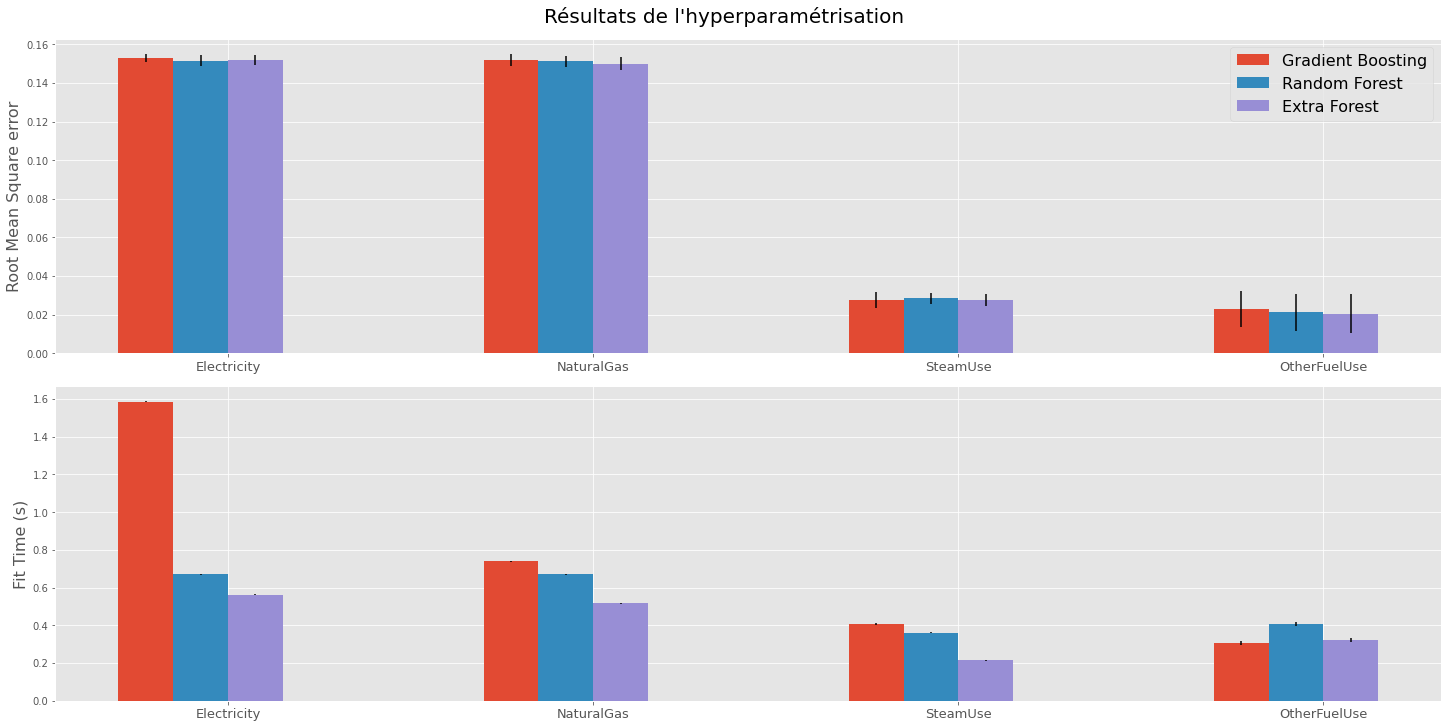

In [187]:
# Graphique des résultats pour les différents modèles et types d'énergies
labels = list_energy_type
x = np.arange(len(labels))

width = 0.15  # the width of the bars
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(20, 10))
y=0
for name_reg in regressors_2.keys():
    ax1.bar(x - 3*width/2 + y ,list(mean_rmse_dict[name_reg].values()), width, label=name_reg)
    ax1.errorbar(x=x - 3*width/2 + y,y=list(mean_rmse_dict[name_reg].values()), yerr= list(std_rmse_dict[name_reg].values()), fmt='none', ecolor='black')

    ax2.bar(x - 3*width/2 + y , list(mean_fit_time_dict[name_reg].values()), width, label=name_reg)
    ax2.errorbar(x=x - 3*width/2 + y, y=list(mean_fit_time_dict[name_reg].values()), yerr=list(std_rmse_dict[name_reg].values()), fmt='none', ecolor='black')

    y = y + width

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Root Mean Square error', size=16)
ax1.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='x', labelsize=13)

ax2.set_ylabel('Fit Time (s)', size=16)

plt.suptitle("Résultats de l'hyperparamétrisation", fontsize=20)
ax1.set_xticks(x)
ax2.set_xticks(x)

ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)

ax1.legend(fontsize=16)
plt.show()

Il y a légère avantage pour l'Extra Forest qui présente la RMSE la moins élevé pour l'ensemble des types d'énergie avec des variances qui permettent une meilleure généralisation du modèle.
En termes de temps d'entrainement du modèle, c'est également l'Extra Forest qui présente les meilleurs résultats

In [434]:
# Les meilleurs modèles sont conservés dans un dictionnaire de modèles
final_model["Electricity"] = rnd_search_results["Electricity"]["Extra Forest"].best_estimator_
final_model["SteamUse"] = rnd_search_results["SteamUse"]["Extra Forest"].best_estimator_
final_model["NaturalGas"] = rnd_search_results["NaturalGas"]["Extra Forest"].best_estimator_
final_model["OtherFuelUse"] = rnd_search_results["OtherFuelUse"]["Extra Forest"].best_estimator_

### 5.3 Prédiction du CO2

Dans cette partie nous allons également évaluer la pertinence de l'ENERGYSTARScore, qui est donc ajouté en tant que variable numérique pour la prédiction du Co2

In [457]:
# Liste des variables numériques pour la prédiction du Co2
num_attribs_Co2 = num_attribs.copy()
# Ajout de l'Energy Star Score dont on va étudier son utilité pour la prédiction du Co2
num_attribs_Co2.extend(["ENERGYSTARScore"])
# Liste des variables catégorielles pour la prédiction du Co2
# qui est strictement la même que pour la prédiction d'énergie
cat_attribs_Co2 = cat_attribs.copy()

#### 5.3.1 Définitions de pipelines pour le Co2

Les prédictions sur les différentes proportions d'énergies remplacent les variables booléennes et la prédiction d'énergie totale est ajoutée comme variable numérique.

In [458]:
class AddEnergyTypePredicted(BaseEstimator, TransformerMixin) :
    
    def __init__(self, list_energy_type) :
        self.list_energy_type = list_energy_type
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Y = []
        for energy_type in self.list_energy_type:
            Y.append(final_model[energy_type].predict(X))
        return np.array(Y).T

In [459]:
# Pipeline pour les variables numériques
num_pipeline_Co2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ('attribs_combined', CombinedAttributesAdder()), # Feature engineering
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline_Co2 = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ])

# Pipeline pour les variables énergétiques (ajout des prédictions)
energy_pipeline = Pipeline([
    # Les consommations d'énergies sont prédites
    ('bool_energy', AddEnergyTypePredicted(list_energy_type + ["SiteEnergyUse(kBtu)"])) 
])

# Pipeline de transformation des variables pour la prédiction du Co2
full_pipeline_co2 = ColumnTransformer([
        ("num", num_pipeline_Co2, num_attribs_Co2),
        ("energyType", energy_pipeline, list(train_set.columns)),
        ("cat", cat_pipeline_Co2, cat_attribs_Co2),
    ])

#### 5.3.2 Hyperparamétrisation du modèle séléctionné

Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 300
	 -  regressor__max_features : 12
	 -  regressor__max_depth : 4
	 -  regressor__learning_rate : 0.05
	 -  preprocess__num__imputer__strategy : mean
	 -  preprocess__cat__imputer__strategy : mean

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.980
	 - Mean of RMSE : 0.265
	 - Ecart-type : 0.009
	 - Coefficient de variation : 3.52 % 

Random Forest
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 16
	 -  regressor__max_depth : 16
	 -  preprocess__num__imputer__strategy : mean
	 -  preprocess__cat__imputer__strategy : mean

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.993
	 - Mean of RMSE : 0.275
	 - Ecart-type : 0.010
	 - Coefficient de variation : 3.65 % 

Extra Forest
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 18
	 -  regressor__max_depth : 18
	 -  preprocess__num__imputer__

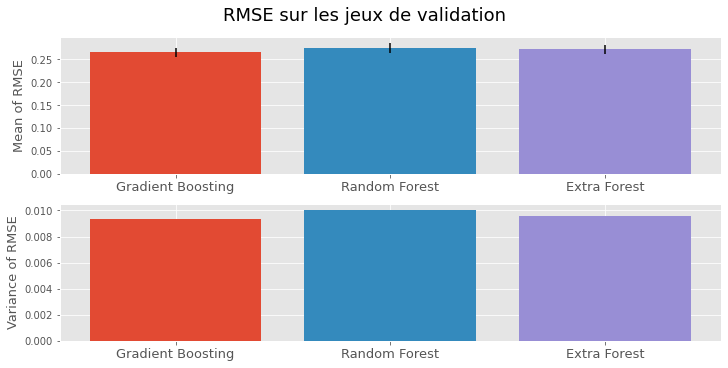

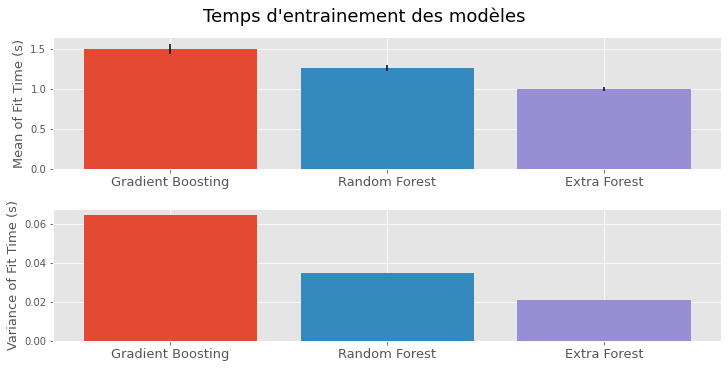

In [460]:
# Selection du meilleur modèle
rnd_search_results["TotalGHGEmissions"] = rnd_search(regressors_2, 
                                                     full_pipeline_co2,
                                                     param_grid,
                                                     train_set,
                                                     train_set["TotalGHGEmissions"])

Le meilleur modèle est le Gradient Boosting avec la RMSE la plus basse et une variance qui permet la généralisation du modèle. Le temps d'entrainement n'est pas beaucoup plus élevé que les autres

In [462]:
# Conservation du meilleur modèle pour la prédiction des gaz à effet de serre
final_model["TotalGHGEmissions"] = rnd_search_results["TotalGHGEmissions"]["Gradient Boosting"].best_estimator_

#### 5.3.3 Sauvegarde des modèles

In [463]:
# 6 Modèles à sauvegarder : SiteEnergyUse(kBtu), Electricity, NaturalGas, SteamUse, OtherFuelUse, TotalGHGEmissions
for label, model in final_model.items() : 
    # Nom du modèle
    filename = 'final_model' + label + '.sav'
    # Sauvegarde du modèle
    pickle.dump(model, open(filename, 'wb'))

### 5.4 Influence de l'ENERGYSTARScore

L'Energy Star Score est un score entre 1 et 100 qui reflète l'efficacité énergétique d'un bâtiment parmi les bâtiments similaires déjà certifiés. Un score de 50 signifie qu'il est dans la médiane alors qu'un score au dessus de 75 indique qu'il s'agit d'un bâtiment à haute performance

In [464]:
def plot_feature_importances(feature_importances, attributes):
    
    # Les features sont triés par importance pour l'affichage graphique
    features = np.array([[feature, attrib] for feature, attrib in sorted(zip(feature_importances, attributes), reverse=True)])
    features_labels = [attrib for value, attrib in sorted(zip(feature_importances, attributes), reverse=True)]
    features_values = [value for value, attrib in sorted(zip(feature_importances, attributes), reverse=True)]

    # Affichage Bar Plot
    fig = plt.figure(1, figsize=(25, 5))
    plt.subplot(121)
    sns.barplot(x=features_labels[0:20], y=[100*v for v in features_values[0:20]], orient='v')
    plt.ylabel("%")
    plt.title("Features Importances")
    plt.xticks(rotation=90)
    
    # Affichage Pieplot ENERGYSTARScore
    plt.subplot(122)
    feat_imp_energystarscore = features_values[features_labels.index('ENERGYSTARScore')]
    values = [1-feat_imp_energystarscore, feat_imp_energystarscore]
    plt.pie(values, labels=["Other Features", "ENERGYSTARScore"],
            autopct='%1.1f%%')
    plt.title("Importance relative de l'ENERGYSTARScore par rapport à l'ensemble des autres features")
    plt.show()

Liste des variables les plus influentes pour la prédiction des émissions de CO2

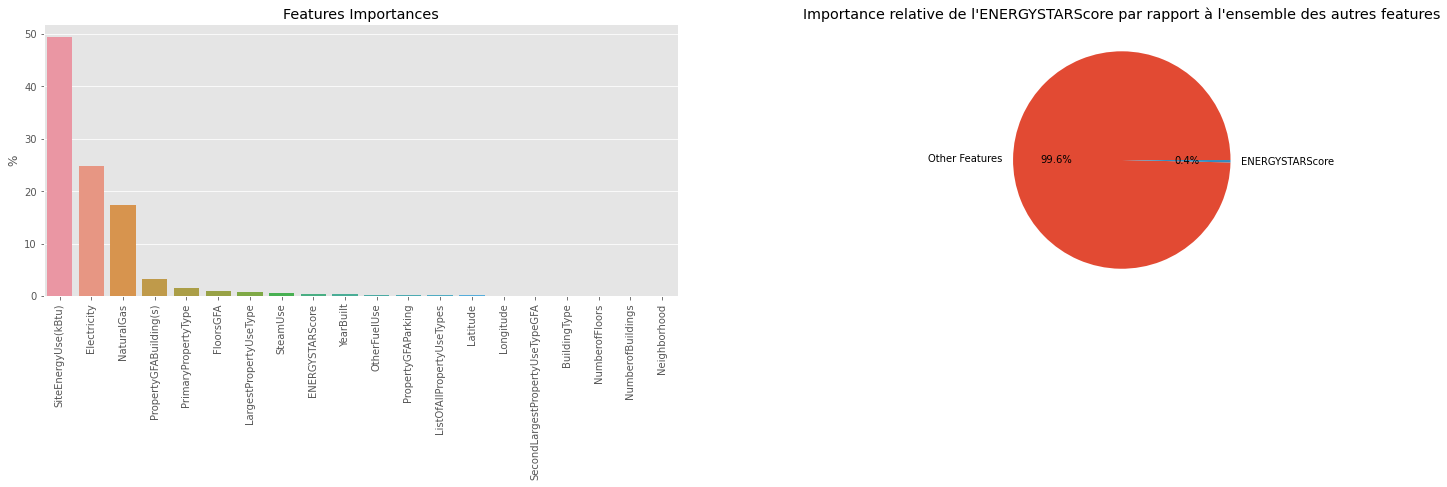

In [465]:
# On récupère les valeurs de l'importance de chaque feature
feature_importances = final_model["TotalGHGEmissions"][-1].feature_importances_

# Liste de tous les attributs
extra_attribs = ["FloorsGFA"]
attributes = num_attribs_Co2 + extra_attribs + list_energy_type + ["SiteEnergyUse(kBtu)"] + cat_attribs_Co2
 
# Affiche le graphique de l'importance des features
plot_feature_importances(feature_importances, attributes)

- On retrouve logiquement que les variables relatives à l'énergie apparaissent en haut du classement puisque physiquement les émissions de Co2 sont le produit de la combustion ou de la production de celles-ci.

- Le label ENERGYSTARScore n'a que très peu d'influence sur le calcul de la prédiction du CO2

## 6. Résultats sur le jeu Test

### 6.1 Prédictions sur les données

In [466]:
# Fonction pour la transformation inverse sur nos variables à prédire
f = lambda x : np.exp(x) - 1
y_test_true = test_set.copy().reset_index()

In [467]:
y_test_pred = pd.DataFrame()

# Resultats sur le jeu Test
print("Resultats sur le jeu Test :", "\n")
for label in ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"] :
    print("_______", label, "_______")

    y_test_pred[label] = final_model[label].predict(test_set)

    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)
    
    r2 = final_model[label].score(test_set, test_set[label]) # r2_score
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # root mean squared error
    mape = mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
    mean_abs_error = mean_absolute_error(y_true, y_pred) # mean absolute error

    
    print("r2 score :", r2)
    print("rmse :", rmse)
    print("mape : {:.2f} %".format(mape))
    print("mean absolute error :", mean_abs_error, "\n")

Resultats sur le jeu Test : 

_______ SiteEnergyUse(kBtu) _______
r2 score : 0.7198332417001192
rmse : 1549955.4197555957
mape : 36.98 %
mean absolute error : 900956.9810340249 

_______ TotalGHGEmissions _______
r2 score : 0.7495767738822638
rmse : 56.675201758220425
mape : 56.49 %
mean absolute error : 28.845475214800985 



### 6.2 Visualisation des erreurs

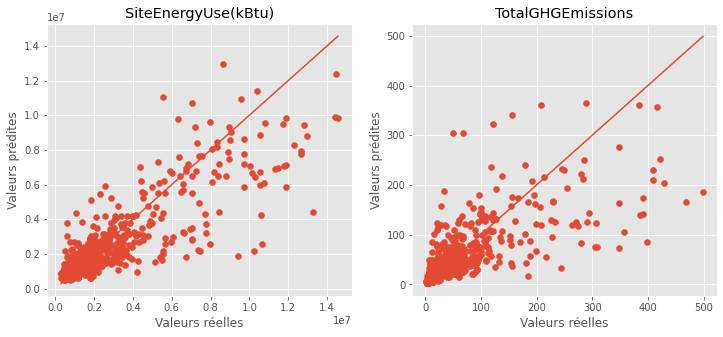

In [468]:
# x : valeurs réelles, y : valeurs prédites
# Graphique 1 : SiteEnergyUse(kBtu)
# Graphique 2 : TotalGHGEmissions
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)

    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)
    
    # x-min et x-max limites
    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    plt.plot([x_min, x_max] ,[x_min, x_max])
    
plt.show()

- Les données sont en nombre beaucoup plus faible pour les bâtiments à haute consommation d'énergie, ce qui explique les mauvaises prédictions.
- Le modèle pourrait éventuellement se contenter de prédire uniquement les bâtiments dont la consommation d'énergie ne dépasse pas 1e7 à 2e7 kBtu.

C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


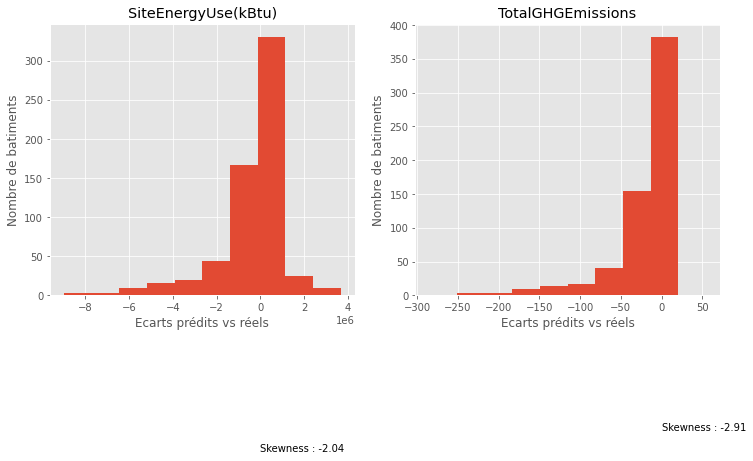

In [297]:
# Histogramme de l'écart entre valeurs prédites et valeurs réelles
# Graphique 1 : SiteEnergyUse(kBtu)
# Graphique 2 : TotalGHGEmissions
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    ax = plt.subplot(1,2,i+1)
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Ecarts prédits vs réels")
    plt.ylabel("Nombre de batiments")
    y = y_test_pred[label].apply(f) - y_test_true[label].apply(f)
    plt.hist(y, bins=int(1 + np.log2(len(test_set))))
    plt.text(0, -200, 'Skewness : ' + str(round(y.skew(),2)))
plt.show()

- L'écart de prédiction est relativement symétrique

### 6.3 Exemples de prédictions de quelques bâtiments

#### Visualisation graphique des erreurs

10 bâtiments sont séléctionnés aléatoirement pour vérifier la qualité du modèle

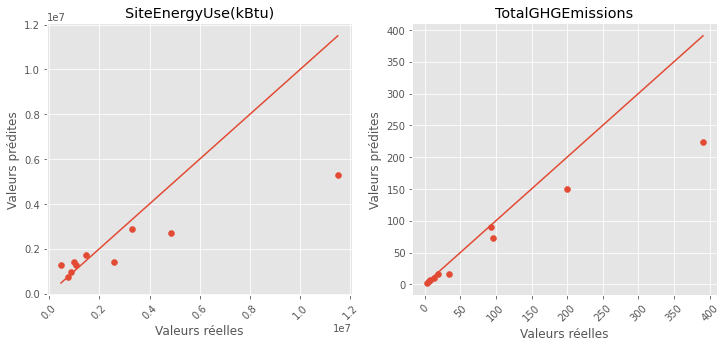

In [298]:
# 10 batiments séléctionnés aléatoirement
nbr_batiments=10
index_bat = np.random.permutation(y_test_true.index)[0:nbr_batiments]

# Séléction des 10 bâtiments
bat_table = y_test_true.loc[index_bat]

fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true.loc[index_bat, label].apply(f), y_test_pred.loc[index_bat, label].apply(f)
    
    bat_table[label]  = y_true
    # Calcul de l'écart relatif entre valeurs réelles et valeurs prédites
    bat_table[label + " %"] = 100*abs(y_true - y_pred)/y_true
    
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)
    
    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    
    plt.xticks(rotation=45)

    plt.plot([x_min, x_max] ,[x_min, x_max])
plt.show()

#### Calcul de l'écart relatif

In [299]:
# Exemple de 10 bâtiments, écarts relatifs : Energie et CO2
bat_table

,OSEBuildingID,BuildingType,PrimaryPropertyType,ComplianceStatus,CouncilDistrictCode,Neighborhood,SecondLargestPropertyUseType,Latitude,Longitude,ThirdLargestPropertyUseTypeGFA,...,ListOfAllPropertyUseTypes,LargestPropertyUseType,ENERGYSTARScore,Electricity,NaturalGas,SteamUse,OtherFuelUse,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu) %,TotalGHGEmissions %
583,27245,MULTIFAMILY LR (1-4),LOW-RISE MULTIFAMILY,NON-COMPLIANT,3,EAST,RETAIL STORE,47.613886,-122.322421,0.0,...,"MULTIFAMILY HOUSING, RETAIL STORE",MULTIFAMILY HOUSING,75.5,0.379214,0.620794,0.0,0.0,2.602404e+06,45.708193,1.996596
75,25295,MULTIFAMILY LR (1-4),LOW-RISE MULTIFAMILY,COMPLIANT,5,NORTH,OFFICE,47.709495,-122.300339,2000.0,...,"MULTIFAMILY HOUSING, OFFICE, PARKING",MULTIFAMILY HOUSING,99.5,1.000020,0.000000,0.0,0.0,9.786857e+05,45.479444,5.704564
454,26146,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,COMPLIANT,7,MAGNOLIA / QUEEN ANNE,PARKING,47.634455,-122.340769,0.0,...,"OFFICE, PARKING",OFFICE,88.5,0.643222,0.356791,0.0,0.0,1.453713e+06,19.629298,54.321095
550,21097,NONRESIDENTIAL,RETAIL STORE,COMPLIANT,7,DOWNTOWN,NOTHING,47.611621,-122.340126,0.0,...,RETAIL STORE,RETAIL STORE,21.0,1.000021,0.000000,0.0,0.0,4.737330e+05,169.178065,32.416471
513,25709,NONRESIDENTIAL,HOTEL,COMPLIANT,2,DOWNTOWN,RESTAURANT,47.597670,-122.324078,0.0,...,"HOTEL, RESTAURANT",HOTEL,NaN,0.259553,0.740452,0.0,0.0,4.846141e+06,44.577669,24.530349
438,21102,NONRESIDENTIAL,RETAIL STORE,COMPLIANT,7,DOWNTOWN,NOTHING,47.612131,-122.341533,0.0,...,RETAIL STORE,RETAIL STORE,91.5,0.867102,0.132917,0.0,0.0,1.051106e+06,20.708923,32.176190
73,24631,MULTIFAMILY LR (1-4),LOW-RISE MULTIFAMILY,COMPLIANT,6,NORTHWEST,NOTHING,47.680850,-122.355016,0.0,...,MULTIFAMILY HOUSING,MULTIFAMILY HOUSING,86.0,0.602493,0.397519,0.0,0.0,7.550915e+05,0.546010,16.075568
587,21549,NONRESIDENTIAL,LABORATORY,COMPLIANT,7,MAGNOLIA / QUEEN ANNE,OFFICE,47.622397,-122.362415,2000.0,...,"LABORATORY, OFFICE, PARKING",LABORATORY,1.0,0.414532,0.585477,0.0,0.0,1.149584e+07,53.956461,42.664307
13,787,NONRESIDENTIAL,WAREHOUSE,COMPLIANT,2,GREATER DUWAMISH,OFFICE,47.576415,-122.338650,4270.0,...,"DATA CENTER, NON-REFRIGERATED WAREHOUSE, OFFIC...",NON-REFRIGERATED WAREHOUSE,NaN,0.515866,0.484145,0.0,0.0,3.283940e+06,12.607170,24.207934
527,19709,MULTIFAMILY LR (1-4),LOW-RISE MULTIFAMILY,COMPLIANT,1,SOUTHWEST,NOTHING,47.589921,-122.393259,0.0,...,MULTIFAMILY HOUSING,MULTIFAMILY HOUSING,77.0,1.000022,0.000000,0.0,0.0,8.837466e+05,11.188085,14.177303


- L'écart relatif pour la consommation d'énergie totale et les émissions de Co2 présente quelques erreurs importantes

## 7. Evaluation des performances 

### 7.1 Influence du nombre d'arbres sur la RMSE

In [300]:
x_train_0 = full_pipeline.fit_transform(train_set, train_set["SiteEnergyUse(kBtu)"])
x_test_0 = full_pipeline.transform(test_set)

# On récupère le meilleur modèle déterminé pour la prédiction de l'énergie
reg = clone(final_model["SiteEnergyUse(kBtu)"][-1])

# Calcul de la RMSE en fonction du nombre d'arbres
range_n_estimators = [x*x for x in range(1, 20)]
errors = []
time_fit, time_predict = [], []

for n_estimators in range_n_estimators :

    reg.set_params(n_estimators=n_estimators)
    start_time_fit = time.time()
    reg.fit(x_train_0, train_set["SiteEnergyUse(kBtu)"])
    time_fit.append(time.time() - start_time_fit)

    start_time_predict = time.time()
    y_pred = reg.predict(x_test_0)
    time_predict.append(time.time() - start_time_predict)

    errors.append(np.sqrt(mean_squared_error(test_set["SiteEnergyUse(kBtu)"], y_pred)))

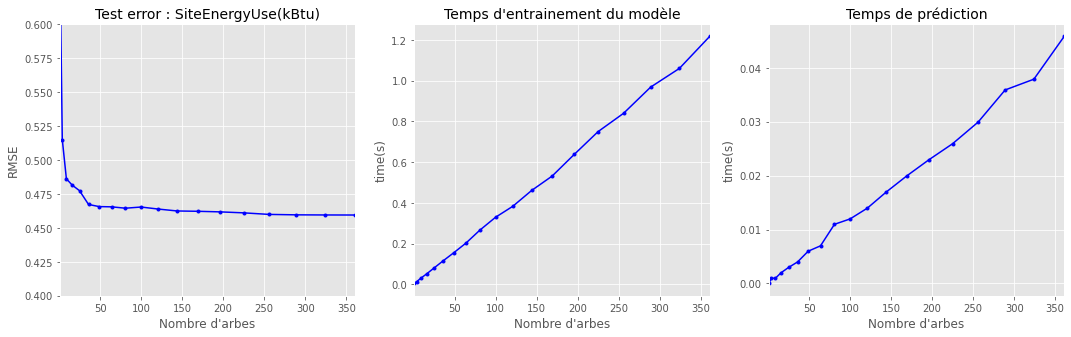

In [301]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
plt.plot(range_n_estimators, errors, "b.-")
plt.xlabel("Nombre d'arbes")
plt.ylabel('RMSE')
plt.xlim(range_n_estimators[0], range_n_estimators[-1])
plt.ylim(0.4, 0.6)
plt.title("Test error : SiteEnergyUse(kBtu)", fontsize=14)

plt.subplot(132)
plt.plot(range_n_estimators, time_fit, "b.-")
plt.xlabel("Nombre d'arbes")
plt.ylabel('time(s)')
plt.xlim(range_n_estimators[0], range_n_estimators[-1])
plt.title("Temps d'entrainement du modèle", fontsize=14)

plt.subplot(133)
plt.plot(range_n_estimators, time_predict, "b.-")
plt.xlabel("Nombre d'arbes")
plt.ylabel('time(s)')
plt.xlim(range_n_estimators[0], range_n_estimators[-1])
plt.title("Temps de prédiction", fontsize=14)

plt.show()

- Augmenter le nombre d'arbres pourrait légèrement augmenter la qualité des résultats
- Le temps de prédiction et d'entrainement varient linéairement avec le nombre d'arbres dans le modèle

### 7.2 Influence  de l'augmentation de la taille du jeu d'entrainement

In [302]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test):
    """
    Graphique de l'évolution de la RMSE en fonction du nombre de données dans le
    jeu d'entrainement
    model(estimator): modèle ML à définir
    X_train(np.array): jeu d'entrainement
    X_test(np.array): jeu de validation
    y_train(np.array): prédiction pour le jeu d'entrainement
    y_train(np.array) : prédiction pour le jeu test
    """
    train_errors, test_errors = [], []
    for m in range(1, len(X_train)):

        model.fit(X_train[:m], y_train[:m]) 
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)   
    return test_errors

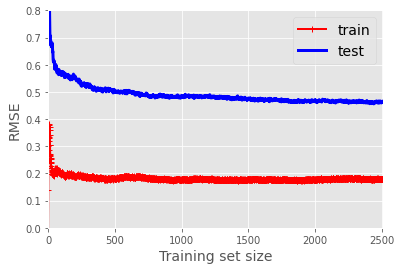

In [303]:
x_train_0 = full_pipeline.fit_transform(train_set, train_set["SiteEnergyUse(kBtu)"])
x_test_0 = full_pipeline.transform(test_set)

reg = final_model["SiteEnergyUse(kBtu)"][-1]

training_size_rmse = plot_learning_curves(reg,
                                          x_train_0,
                                          x_test_0,
                                          train_set["SiteEnergyUse(kBtu)"],
                                          test_set["SiteEnergyUse(kBtu)"])
plt.axis([0, len(x_train_0), 0, 0.8])                         
plt.show()         

L'erreur sur les données d'entrainement est largement inférieure à l'erreur sur le jeu test, ce qui est la marque d'un modèle qui surajuste. Compte tenu de la pente négative de l'erreur sur le jeu test, le meilleur moyen d'améliorer le modèle est d'augmenter la taille du jeu d'entrainement.